In [2]:
# Run once
%cd ..

/Users/lena/modconn/harvard_cs282_ptg


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import datasets
import torch
from modconn import curves
from datasets import get_model_class
from datasets.tabular import TabularModel, TabularModelCurve, TabularModelPerturb
from style import bold
from similarity import get_top_k, average_pairwise_score, top_k_sa, average_ground_truth_score, ground_truth_score
from tqdm import tqdm
from torch.utils.data import DataLoader
from util import get_weight_diff, get_weight_norm, linear_weight_interpolation
from align import compute_model_alignment, align_models, align_tabular
from fusion import align_networks, load_aligned_model
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
name = 'heloc'  # or 'heloc'
n_models = 1000
random_sources = ['rs', 'loo']

# Random source
random_source = random_sources[0]
print(bold("Random source:"), random_source)

optim = 'adam'
epochs = 30
batch_size = 32
lr = 0.0004
# optim = 'sgd'
# epochs = 20
# lr = 0.1
# batch_size = 64
dropout = 0
directory = f'models/{name}/{random_source}/{optim}_epochs{epochs}_lr{lr}_batch{batch_size}_dropout{dropout}'
print(bold("Directory:"), directory)

trainset, testset = datasets.load_dataset(name)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=False)
X_train, y_train = trainset.data.numpy(), trainset.labels.numpy()
X_test, y_test = testset.data.numpy(), testset.labels.numpy()
n_inputs, n_features = X_test.shape
model_args = [n_features, datasets.tabular.layers[name]]
layer_str = 'network.0.weight'

def load_model(idx):
    model_class = get_model_class(name)
    model = model_class(*model_args)
    state_dict = torch.load(f'{directory}/model_{idx}.pth')
    model.load_state_dict(state_dict)
    return model

Random source: rs
Directory: models/heloc/rs/adam_epochs30_lr0.0004_batch32_dropout0


In [5]:
def init_model(idx):
    model_class = get_model_class(name)
    torch.manual_seed(idx)
    model = model_class(*model_args)
    return model

def get_model_from_curve(p_curve, t):
    model_class = get_model_class(name)
    # Get the state_dict at t
    state_dict_values = p_curve.weights(t=t, concatenate=False)
    state_dict = torch.load(f'{directory}/model_{0}.pth')
    for i, key in enumerate(state_dict.keys()):
        state_dict[key] = state_dict_values[i]
    # Create the model
    m = model_class(*model_args)
    m.load_state_dict(state_dict)
    return m

In [6]:
def get_curves_gradients(p_curves, ts=np.linspace(0.0, 1.0, 101)):
    # Takes in list of curves, and computes gradients for each curve at each point on the curve
    # Returns a list of gradients
    curve_grads = np.zeros((len(p_curves), len(ts), *X_test.shape))
    for i, p_curve in enumerate(p_curves):
        for j, t in enumerate(ts):
            model = get_model_from_curve(curve=p_curve, t=t)
            curve_grads[i,j] = model.compute_gradients(X_test, return_numpy=True)
    return curve_grads

def perturb_curve(p_curve, ts, n_weight_perturbations, sigma, disable_tqdm=True):
    state_dicts = [get_model_from_curve(p_curve, t).state_dict() for t in ts]
    return perturb_segment(state_dicts, n_weight_perturbations, sigma, disable_tqdm=disable_tqdm)

def perturb_segment(state_dicts, n_weight_perturbations, sigma, disable_tqdm=True):
    model_class = get_model_class(name)
    logits_smooth = np.zeros((len(state_dicts), n_weight_perturbations, *y_test.shape, 2))
    grads_smooth = np.zeros((len(state_dicts), n_weight_perturbations, *X_test.shape))

    for i, state_dict in tqdm(enumerate(state_dicts), disable=disable_tqdm):
        model = model_class(*model_args)
        model.load_state_dict(state_dict)
        pert_model = TabularModelPerturb(model, n_weight_perturbations, sigma)
        logits_smooth[i] = pert_model.forward(torch.FloatTensor(X_test)).detach().numpy()
        grads_smooth[i] = pert_model.compute_gradients(X_test, mean=False)
    
    return logits_smooth, grads_smooth

def eval_segment(state_dicts, disable_tqdm=True):
    model_class = get_model_class(name)
    logits = np.zeros((len(state_dicts), *y_test.shape, 2))
    grads = np.zeros((len(state_dicts), *X_test.shape))

    for i, state_dict in tqdm(enumerate(state_dicts), disable=disable_tqdm):
        model = model_class(*model_args)
        model.load_state_dict(state_dict)
        logits[i] = model.forward(torch.FloatTensor(X_test)).detach().numpy()
        grads[i] = model.compute_gradients(X_test)

    return logits, grads

In [7]:
def mode_connect(models, trainloader, lr, epochs, curve_type='polychain', optim='sgd',
                 ts=np.linspace(0, 1, 101), disable_tqdm=True, fix_start=False, fix_end=False):
    if curve_type == 'polychain':
        curve_type = curves.PolyChain
    elif curve_type == 'bezier':
        curve_type = curves.Bezier
    else:
        raise ValueError(f'Unknown curve type {curve_type}')
    p_curve = curves.train_curve(models=models, trainloader=trainloader,
                                 curve_class=TabularModelCurve, curve=curve_type,
                                 input_size=model_args[0], hidden_layers=model_args[1],
                                 fix_start=fix_start, fix_end=fix_end, optim=optim,
                                 lr=lr, epochs=epochs, disable_tqdm=disable_tqdm)
    # Compute gradients
    p_curve_logits = np.zeros((len(ts), *y_test.shape, 2))
    p_curve_grads = np.zeros((len(ts), *X_test.shape))
    for j, t in enumerate(ts):
        model = get_model_from_curve(p_curve=p_curve, t=t)
        p_curve_logits[j] = model.forward(torch.FloatTensor(X_test)).detach().numpy()
        p_curve_grads[j] = model.compute_gradients(X_test, return_numpy=True)
    return p_curve, p_curve_logits, p_curve_grads

In [8]:
def get_curve_statistics(p_curve, ts=np.linspace(0,1,101)):
    # Compute losses
    loss_fn = torch.nn.functional.cross_entropy
    p_curve_loss = np.zeros(len(ts))
    p_curve_loss_tr = np.zeros(len(ts))
    p_curve_preds_tr = np.zeros((len(ts), *y_train.shape))
    p_curve_grads_tr = np.zeros((len(ts), *X_train.shape))
    for i, t in enumerate(ts):
        model = get_model_from_curve(p_curve=p_curve, t=t)
        p_curve_loss[i] = loss_fn(model.forward(torch.FloatTensor(X_test)), torch.tensor(y_test)).item()
        p_curve_loss_tr[i] = loss_fn(model.forward(torch.FloatTensor(X_train)), torch.tensor(y_train)).item()
        p_curve_preds_tr[i] = model.predict(X_train, return_numpy=True)
        p_curve_grads_tr[i] = model.compute_gradients(X_train, return_numpy=True)
    weight_norms = np.zeros(len(ts))
    weight_diffs = np.zeros(len(ts))
    for i, t in enumerate(ts):
        model_t = get_model_from_curve(p_curve=p_curve, t=t)
        model_0 = get_model_from_curve(p_curve=p_curve, t=0)
        weight_norms[i] = get_weight_norm(model_t.state_dict())
        weight_diffs[i] = get_weight_diff(model_t.state_dict(), model_0.state_dict())
    return p_curve_loss, p_curve_loss_tr, p_curve_preds_tr, p_curve_grads_tr, weight_norms, weight_diffs

def plot_statistics(p_curve_loss, p_curve_loss_tr,
                    p_curve_preds, p_curve_preds_tr,
                    p_curve_grads, p_curve_grads_tr,
                    weight_norms, weight_diffs, ts=np.linspace(0,1,101)):
    fig, ax = plt.subplots(1, 5, figsize=(20, 4), dpi=150)
    ax[0].plot(ts, p_curve_loss, label='Test')
    ax[0].plot(ts, p_curve_loss_tr, label='Train')

    ax[1].plot(ts, 100*(p_curve_preds==y_test).mean(axis=1), label='Test')
    ax[1].plot(ts, 100*(p_curve_preds_tr==y_train).mean(axis=1), label='Train')

    q = np.quantile(np.linalg.norm(p_curve_grads, axis=2), [0.25, 0.5, 0.75], axis=1)
    ax[2].plot(ts, q[1], label='Test')
    ax[2].fill_between(ts, q[0], q[2], alpha=0.2)
    q = np.quantile(np.linalg.norm(p_curve_grads_tr, axis=2), [0.25, 0.5, 0.75], axis=1)
    ax[2].plot(ts, q[1], label='Train')
    ax[2].fill_between(ts, q[0], q[2], alpha=0.2)

    topk, signs = get_top_k(5, p_curve_grads, return_sign=True)
    gt_score = ground_truth_score(topk, signs, gt, signs_gt, top_k_sa)
    q = np.quantile(gt_score, [0.25, 0.5, 0.75], axis=1)
    ax[3].plot(ts, q[1], label='Test')
    ax[3].fill_between(ts, q[0], q[2], alpha=0.2)

    ax[4].plot(ts, weight_norms, label='Weight Norm')
    ax[4].plot(ts, weight_diffs, label='Weight Diff')

    titles = ['Loss', 'Accuracy (%)', 'Gradient Norm', 'Ground Truth SA Similarity', 'Weight Norm']
    for i in range(5):
        ax[i].set_xlabel('t')
        ax[i].legend()
        ax[i].set_title(titles[i])
    plt.show()

In [9]:
grads = np.array([np.load(f'{directory}/grads_{idx}.npy') for idx in range(n_models)])
gt, signs_gt = get_top_k(5, grads.mean(axis=0), return_sign=True)
tk, s = get_top_k(5, grads, return_sign=True)
orig_sa = average_ground_truth_score(tk, s, gt, signs_gt, top_k_sa)

### Some captum bs

In [8]:
from captum.attr import DeepLift

/Users/lena/.pyenv/versions/3.9.16/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
model = load_model(0)
DLS = DeepLift(model)
x = torch.FloatTensor(X_test)
x.requires_grad = True
dls = DLS.attribute(x, target=1).detach().numpy()

/Users/lena/.pyenv/versions/3.9.16/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


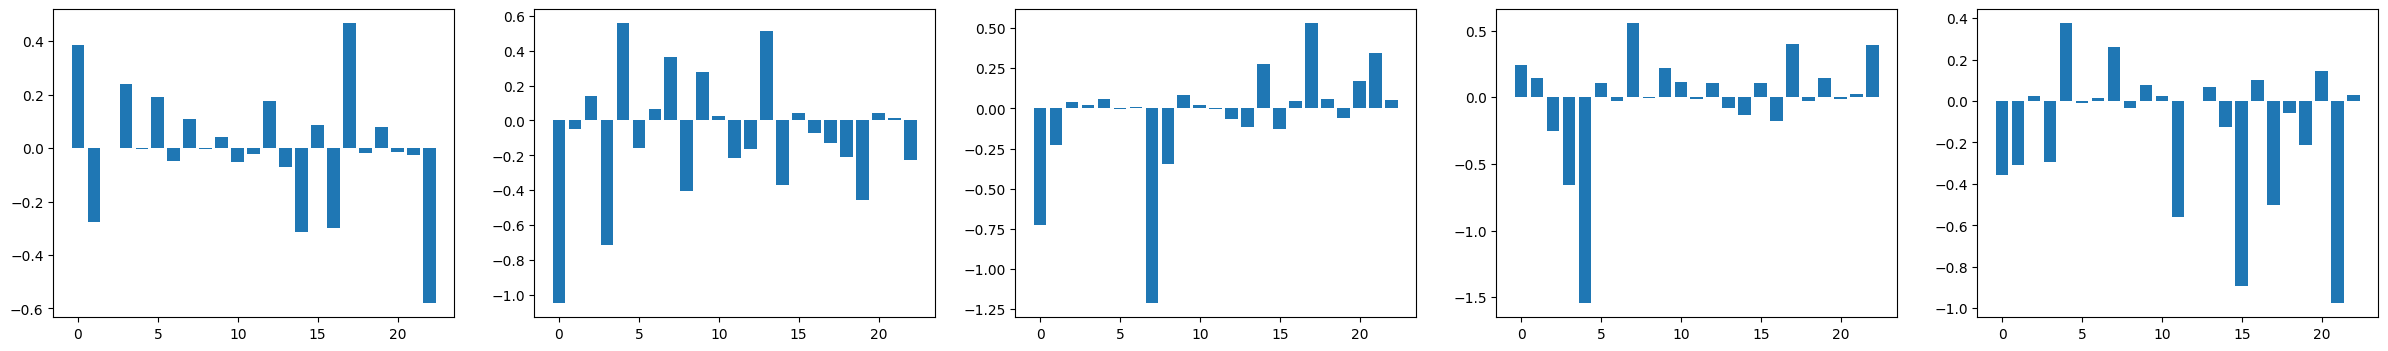

In [33]:
g = np.load(f'{directory}/grads_0.npy')[:5]
plot_grads(g*X_test[:5], nrows=1, ncols=g.shape[0])

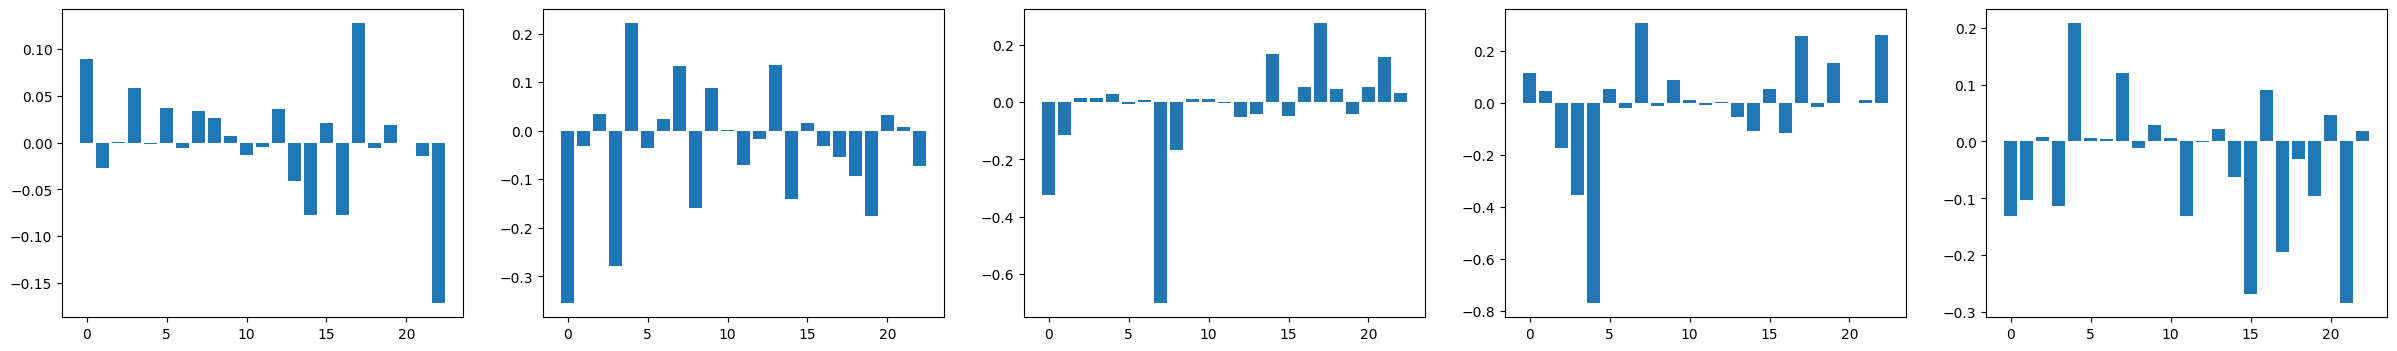

In [30]:
from style import plot_grads
plot_grads(dls, nrows=1, ncols=dls.shape[0])

In [101]:
ks = DeepLiftShap(model)
n_samples = 500
kshaps = np.zeros((n_samples, X_test.shape[1]))
for i in tqdm(range(n_samples)):
    kshaps[i] = ks.attribute(torch.FloatTensor(X_test[i:i+1])).detach().numpy()

  0%|          | 0/500 [00:00<?, ?it/s]


TypeError: attribute() missing 1 required positional argument: 'baselines'

In [94]:
model = load_model(0)
ks = KernelShap(model)
n_samples = 2000
kshaps = np.zeros((100, X_test.shape[1]))
for i in tqdm(range(100)):
    kshaps[i] = ks.attribute(torch.FloatTensor(X_test[i:i+1]),
    target=1, n_samples=n_samples, perturbations_per_eval=5000).detach().numpy()

100%|██████████| 100/100 [00:14<00:00,  7.14it/s]


In [95]:
14*1000/60/60

3.888888888888889

In [91]:
tk_ks, s_ks = get_top_k(5, kshaps, return_sign=True)
ks_sa = average_pairwise_score(tk_ks, s_ks, top_k_sa)

In [92]:
ks_sa

array([0.96      , 0.82222222, 0.92888889, 0.96      , 0.76      ,
       0.82666667, 1.        , 0.96      , 0.74222222, 0.87111111,
       0.84      , 0.87111111, 0.90666667, 0.89777778, 0.96      ,
       0.76444444, 0.92888889, 0.73333333, 1.        , 0.79111111])

In [ ]:
ks_sa

array([1.        , 0.80888889, 1.        , 1.        , 0.92444444])

In [ ]:
ks_sa

array([1.        , 0.81333333, 1.        , 1.        , 0.8       ])

In [67]:
ks_sa

array([0.96      , 0.77333333, 0.90666667, 0.88      , 0.61333333])

In [ ]:
ks_sa

array([0.96      , 0.66666667, 0.96      , 0.89777778, 0.73333333])

In [ ]:
ks_sa

array([0.8       , 0.61333333, 0.86666667, 0.79555556, 0.45333333])

In [13]:
import shap
model = load_model(0)
explainer = shap.DeepExplainer(model, torch.FloatTensor(X_train))
shap_values = explainer.shap_values(torch.FloatTensor(X_test[:10]))

### Modconn

In [50]:
# Arguments for OT-Fusion
class Args:
    def __init__(self):
        self.ground_metric = 'euclidean'
        self.ground_metric_normalize = 'none'
        self.reg = 1
        self.not_squared = False
        self.ground_metric_eff = False
        self.clip_min = 0
        self.clip_max = 1000
        self.clip_gm = False
        self.dist_normalize = True
        self.activation_histograms = True
        self.act_num_samples = 100
        self.geom_ensemble_type = 'wts'
        self.normalize_wts = False
        self.debug = False
        self.exact = True
        self.unbalanced = True
        self.past_correction = False
        self.ensemble_step = 0.9
        self.bias = True

args = Args()
model_0 = load_model(0)
model_1 = init_model(1)
networks = [model_1, model_0]

# Align model 1 to model 0
avg_aligned_layers = align_networks(args, networks)
model_a = load_aligned_model(avg_aligned_layers, TabularModel,
                                   model_args, bias=args.bias)
curve_models = [model_0, model_a]

Previous layer shape is  None
Processing the coordinates to form ground_metric
diff is  torch.Size([128, 128, 23])
cost matrix is  torch.Size([128, 128])
Shape of transport map is  torch.Size([128, 128])
geomtric fc shape is torch.Size([128, 23])
Previous layer shape is  torch.Size([128, 23])
shape of layer: model 0 torch.Size([128])
shape of layer: model 1 torch.Size([128])
shape of previous transport map torch.Size([128, 128])
Processing the coordinates to form ground_metric
diff is  torch.Size([128, 128])
cost matrix is  torch.Size([128, 128])
ground metric shape is  torch.Size([128, 128])
Shape of transport map is  torch.Size([128, 128])
bias shape torch.Size([128])
geomtric fc shape is torch.Size([128])
Previous layer shape is  torch.Size([128])
shape of layer: model 0 torch.Size([64, 128])
shape of layer: model 1 torch.Size([64, 128])
shape of previous transport map torch.Size([128, 128])
Processing the coordinates to form ground_metric
diff is  torch.Size([64, 64, 128])
cost mat

In [56]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)
model_0 = load_model(0)
model_1 = load_model(1)
model_2 = load_model(2)
model_1_to_0 = align_tabular(model_1, model_0, trainloader, model_args)  # align model 1 to model 0
model_0_to_1 = align_tabular(model_0, model_1, trainloader, model_args)  # align model 0 to model 1
model_a2 = align_tabular(model_2, model_0, trainloader, model_args)  # align model 2 to model 0
curve_models = [model_0, model_1_to_0, model_0_to_1, model_1]#, model_a2]

100%|██████████| 60/60 [00:20<00:00,  2.88it/s]


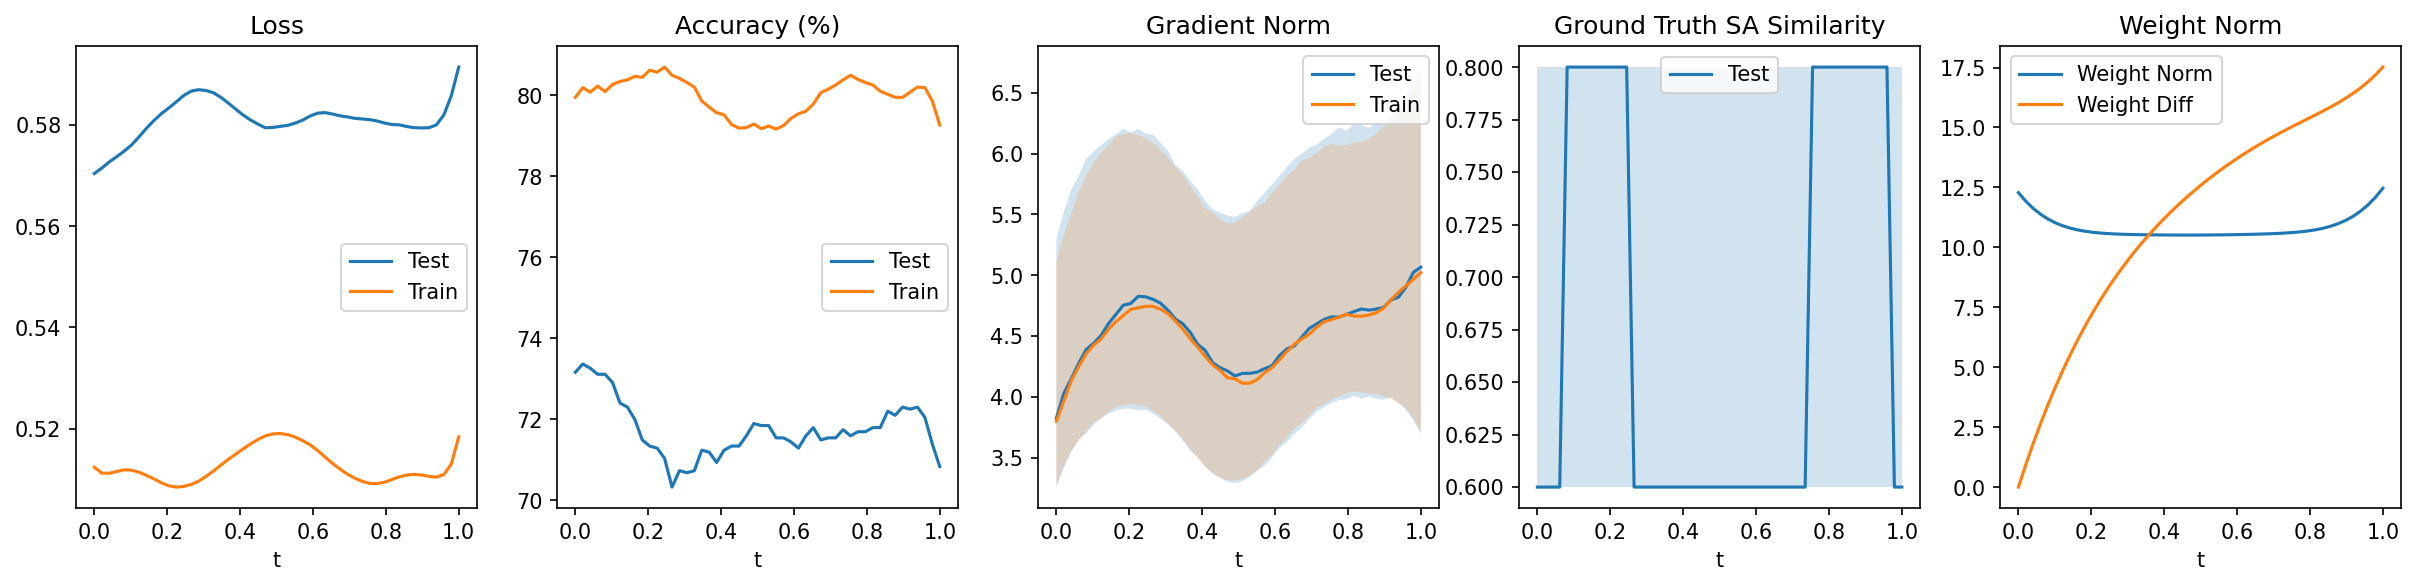

In [60]:
ts = np.linspace(0, 1, 50)
p_curve, p_curve_preds, p_curve_grads = mode_connect(curve_models, trainloader=trainloader, lr=lr, optim=optim,
                                                     epochs=60, curve_type='bezier', ts=ts,
                                                     disable_tqdm=False, fix_start=True, fix_end=True)
outputs = get_curve_statistics(p_curve, ts=ts)
p_curve_loss, p_curve_loss_tr, p_curve_preds_tr, p_curve_grads_tr, weight_norms, weight_diffs = outputs
plot_statistics(p_curve_loss, p_curve_loss_tr, p_curve_preds.argmax(axis=2), p_curve_preds_tr,
                p_curve_grads, p_curve_grads_tr, weight_norms, weight_diffs, ts=ts)

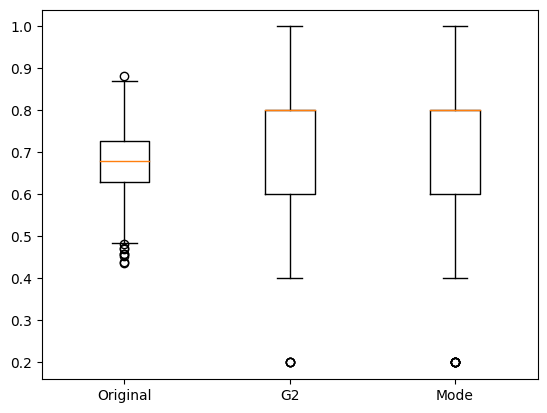

0.7634430379746836 0.7563544303797468


In [61]:
#model_idx = [10] + [11+i for i in range(num_bends)] + [11+num_bends]
model_idx = range(2)
g2 = np.array([np.load(f'{directory}/grads_{idx}.npy') for idx in model_idx]).mean(axis=0)
tk_g2, s_g2 = get_top_k(5, g2, return_sign=True)
sa_g2 = top_k_sa(tk_g2, gt, s_g2, signs_gt)
tk_mode, s_mode = get_top_k(5, p_curve_grads.mean(axis=0), return_sign=True)
sa_mode = top_k_sa(tk_mode, gt, s_mode, signs_gt)
plt.boxplot([orig_sa, sa_g2, sa_mode], labels=['Original', 'G2', 'Mode'])
plt.show()
print(sa_mode.mean(), sa_g2.mean())

In [30]:
ts = np.linspace(0, 1, 50)
num_bends = 2
grads_e = []
grads_mode = []
for trial in tqdm(range(10)):
    model_idx = np.random.choice(n_models, num_bends+2, replace=False)
    models = [load_model(model_idx[0])]+[init_model(i) for i in model_idx[1:-1]]+[load_model(model_idx[-1])]
    p_curve, p_curve_preds, p_curve_grads = mode_connect(models, trainloader=trainloader, lr=lr, optim=optim,
                                                        epochs=100, curve_type='bezier', ts=ts,
                                                        disable_tqdm=False, fix_start=True, fix_end=True)
    grads_e.append(np.array([np.load(f'{directory}/grads_{idx}.npy') for idx in model_idx]).mean(axis=0))
    grads_mode.append(p_curve_grads)
grads_e = np.array(grads_e)
grads_mode = np.array(grads_mode)

100%|██████████| 10/10 [01:43<00:00, 10.37s/it]


In [31]:
grads_mode.shape

(10, 51, 1975, 23)

In [32]:
k = 5
grads = np.array([np.load(f'{directory}/grads_{idx}.npy') for idx in range(n_models)])
gt, signs_gt = get_top_k(k, grads.mean(axis=0), return_sign=True)

tk, s = get_top_k(k, grads, return_sign=True)
orig_sa = average_ground_truth_score(tk, s, gt, signs_gt, top_k_sa)

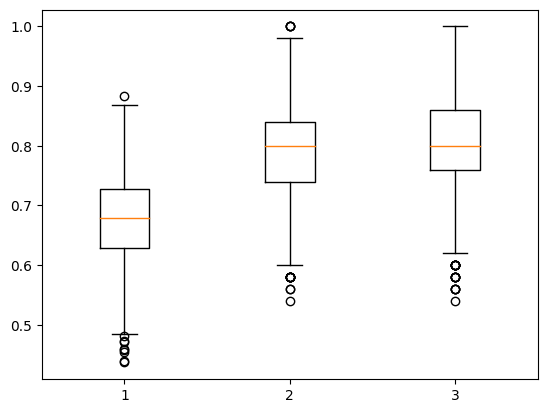

In [33]:
tk_mode, s_mode = get_top_k(k, grads_mode.mean(axis=1), return_sign=True)
mode_sa = average_ground_truth_score(tk_mode, s_mode, gt, signs_gt, top_k_sa)

tk_e, s_e = get_top_k(k, grads_e, return_sign=True)
e_sa = average_ground_truth_score(tk_e, s_e, gt, signs_gt, top_k_sa)

plt.boxplot([orig_sa, e_sa, mode_sa])
plt.show()

In [62]:
grads_mode.shape

(10, 51, 1975, 23)

In [64]:
tk1, s1 = get_top_k(5, grads_e[:5].mean(axis=0), return_sign=True)
tk2, s2 = get_top_k(5, grads_e[5:].mean(axis=0), return_sign=True)
g1_sa = top_k_sa(tk1, gt, s1, signs_gt)
g2_sa = top_k_sa(tk2, gt, s2, signs_gt)

tkm1, sm1 = get_top_k(5, grads_mode[:5].mean(axis=(0,1)), return_sign=True)
tkm2, sm2 = get_top_k(5, grads_mode[5:].mean(axis=(0,1)), return_sign=True)
m1_sa = top_k_sa(tkm1, gt, sm1, signs_gt)
m2_sa = top_k_sa(tkm2, gt, sm2, signs_gt)

g15_sa = average_ground_truth_score(np.array([tk1, tk2]), np.array([s1, s2]), gt, signs_gt, top_k_sa)
m15_sa = average_ground_truth_score(np.array([tkm1, tkm2]), np.array([sm1, sm2]), gt, signs_gt, top_k_sa)

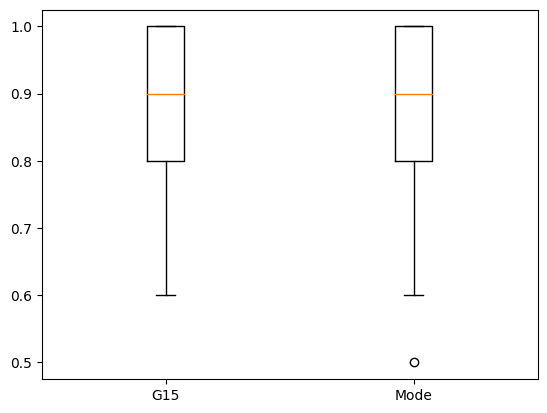

In [65]:
plt.boxplot([g15_sa, m15_sa], labels=['G15', 'Mode'])
plt.show()

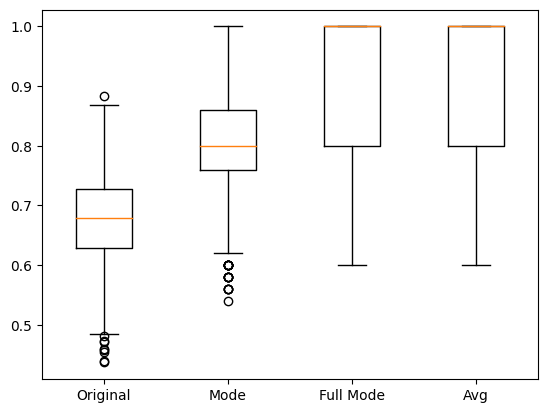

In [45]:
orig_sa = average_ground_truth_score(tk, s, gt, signs_gt, top_k_sa)
tk_mode, s_mode = get_top_k(5, grads_mode.mean(axis=1), return_sign=True)
mode_sa = average_ground_truth_score(tk_mode, s_mode, gt, signs_gt, top_k_sa)
gm30 = grads_mode.mean(axis=(0,1))
tk_gm30, s_gm30 = get_top_k(5, gm30, return_sign=True)
gm30_sa = top_k_sa(tk_gm30, gt, s_gm30, signs_gt)
g30 = grads_e.mean(axis=0)
tk_g30, s_g30 = get_top_k(5, g30, return_sign=True)
g30_sa = top_k_sa(tk_g30, gt, s_g30, signs_gt)
plt.boxplot([orig_sa, mode_sa, gm30_sa, g30_sa], labels=['Original', 'Mode', 'Full Mode', 'Avg'])
plt.show()

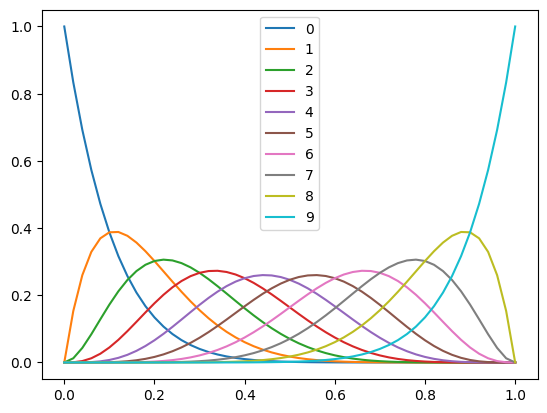

In [72]:
coeff = np.zeros((len(ts), 10))
for i, t in enumerate(ts):
    coeff[i] = p_curve.coeff_layer(t)
for i in range(coeff.shape[1]):
    plt.plot(ts, coeff[:,i], label=f'{i}')
plt.legend()
plt.show()

In [63]:
orig_preds = np.zeros((2, len(X_test)))
orig_grads = np.zeros((2, len(X_test), 23))
for i in range(2):
    model = load_model(i)
    orig_preds[i] = model.predict(X_test, return_numpy=True)
    orig_grads[i] = model.compute_gradients(X_test, return_numpy=True)
orig_tk, orig_s = get_top_k(5, orig_grads, return_sign=True)

In [73]:
epoch = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
predsim = np.zeros((2, len(epoch), len(ts)))
gradsim = np.zeros((2, len(epoch), len(ts)))
sa = np.zeros((2, len(epoch), len(ts), n_inputs))
for i, ep in enumerate(epoch):
    models = [init_model(i) for i in range(2)]
    p_curve, p_curve_preds, p_curve_grads = mode_connect(models, trainloader=trainloader, lr=lr, optim=optim,
                                                     epochs=ep, curve_type='bezier', ts=ts,
                                                     disable_tqdm=False, fix_start=False, fix_end=False)
    for m in range(2):
        predsim[m,i] = (p_curve_preds.argmax(axis=2)==orig_preds[m]).mean(axis=1)
        gradsim[m,i] = np.linalg.norm(p_curve_grads-orig_grads[m], axis=2).mean(axis=1)
        ep_tk, ep_s = get_top_k(5, p_curve_grads, return_sign=True)
        for j, t in enumerate(ts):
            sa[m,i,j] = top_k_sa(orig_tk[m], ep_tk[j], orig_s[m], ep_s[j])

0it [00:00, ?it/s]
100%|██████████| 50/50 [00:05<00:00,  9.72it/s]


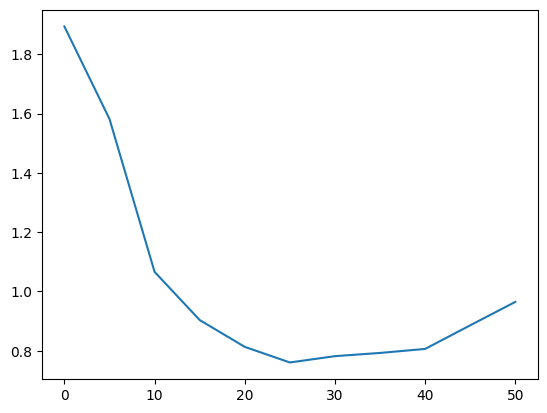

In [85]:
plt.plot(epoch, gradsim[0,:,0])
plt.show()

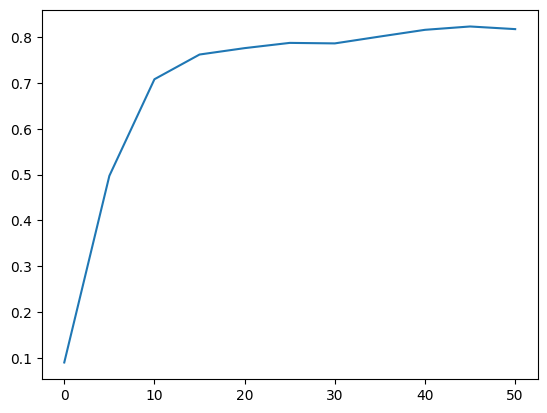

In [84]:
plt.plot(epoch, np.mean(sa[0, :, 0], axis=1))
plt.show()

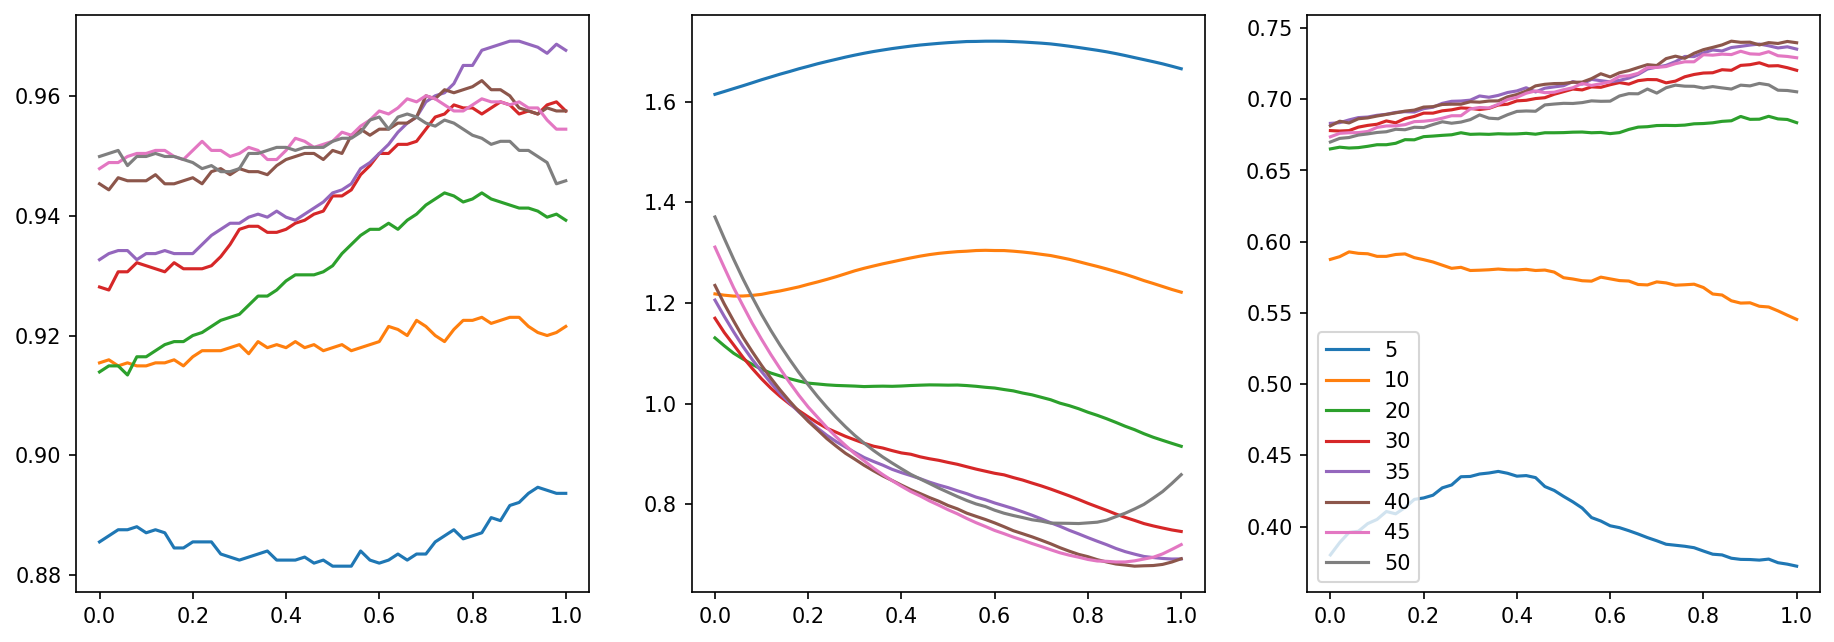

In [76]:
fig, ax = plt.subplots(1, 3, figsize=(15,5), dpi=150)
idx = 1
for i, ep in enumerate(epoch):
    if ep in [5, 10, 20, 30, 35, 40, 45, 50]:
        ax[0].plot(ts, predsim[idx, i], label=f'{ep}')
        ax[1].plot(ts, gradsim[idx, i], label=f'{ep}')
        ax[2].plot(ts, sa[idx, i].mean(axis=1), label=f'{ep}')
plt.legend()
plt.show()

In [58]:
preds0
preds20 = np.zeros((2, len(X_test)))
grads20 = np.zeros((2, len(X_test), 23))

for i in range(2):
    model = load_model(i)
    preds20[i] = 
    grads20[i] = 

TabularModel(
  (network): Sequential(
    (0): Linear(in_features=23, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=2, bias=True)
    (7): Softmax(dim=-1)
  )
)

100%|██████████| 30/30 [00:03<00:00,  8.14it/s]


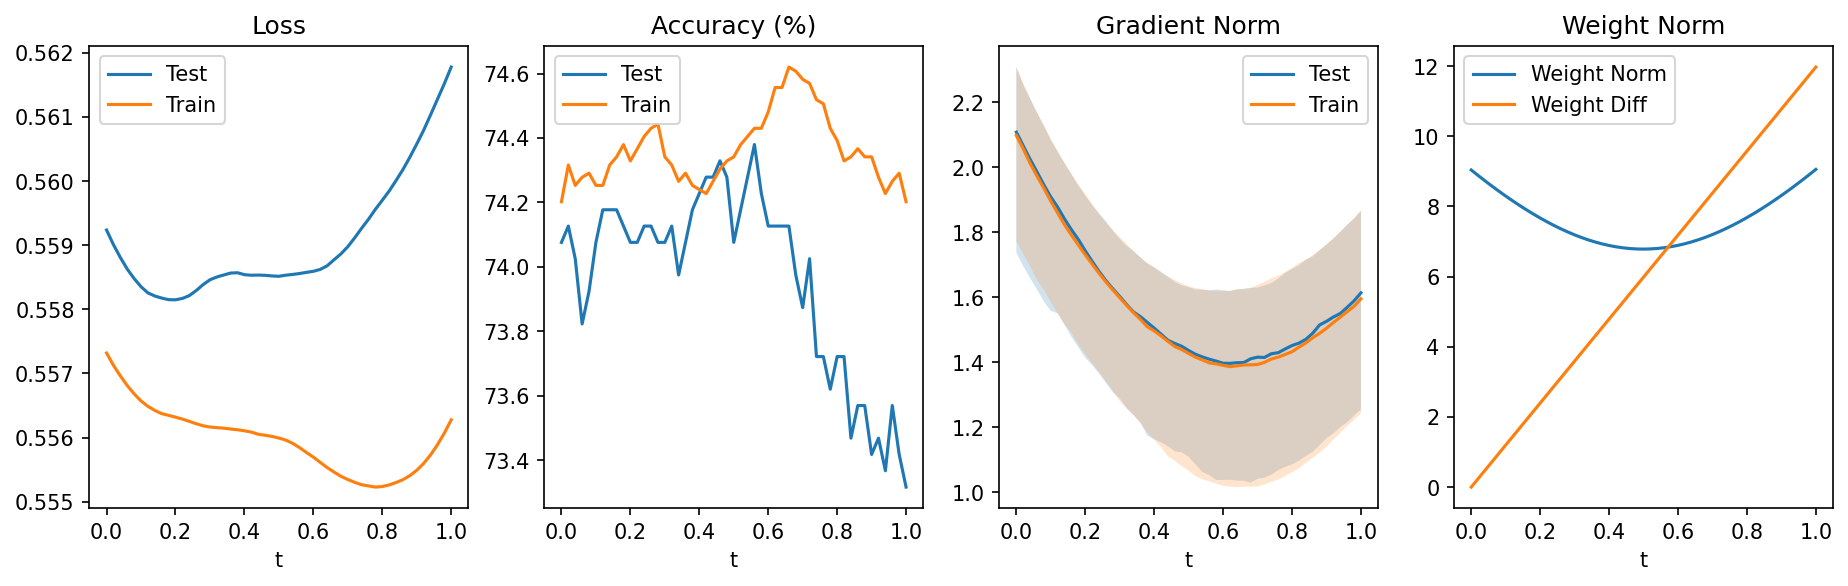

In [ ]:
ts = np.linspace(0, 1, 51)
model_class = get_model_class(name)
models = [init_model(i) for i in range(2)]
torch.manual_seed(9)
p_curve, p_curve_preds, p_curve_grads = mode_connect(models, trainloader=trainloader, lr=lr, optim=optim,
                                                     epochs=epochs+10, curve_type='bezier', ts=ts,
                                                     disable_tqdm=False, init='none', target_loss=0)
outputs = get_curve_statistics(p_curve, ts=ts)
p_curve_loss, p_curve_loss_tr, p_curve_preds_tr, p_curve_grads_tr, weight_norms, weight_diffs = outputs
plot_statistics(p_curve_loss, p_curve_loss_tr, p_curve_preds.argmax(axis=2), p_curve_preds_tr,
                p_curve_grads, p_curve_grads_tr, weight_norms, weight_diffs, ts=ts)

100%|██████████| 15/15 [00:01<00:00,  7.89it/s]


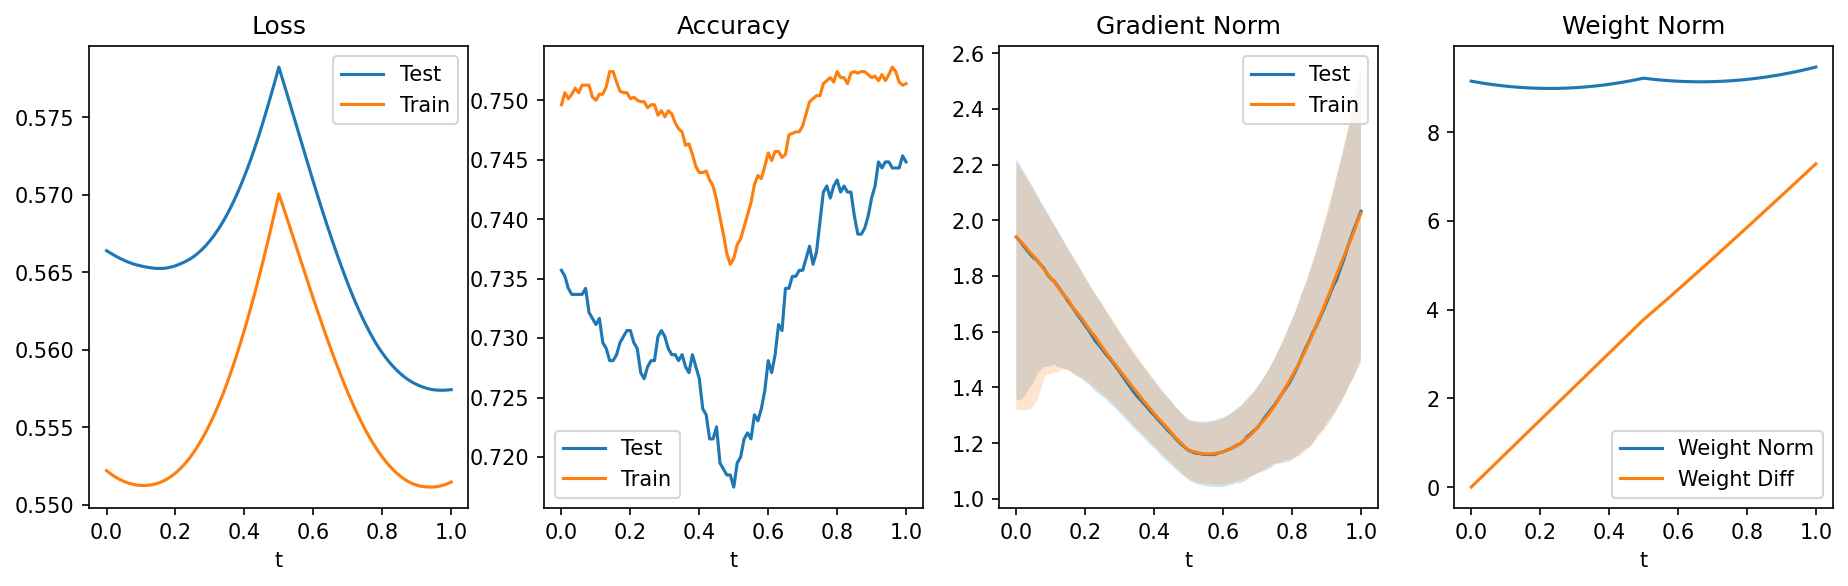

In [28]:
mid_model = get_model_from_curve(p_curve, t=0.5)
p_curve2, p_curve_preds2, p_curve_grads2 = mode_connect([start_model, mid_model], trainloader=trainloader_full,
                                                     num_bends=3, lr=0.04, momentum=0,
                                                     epochs=15, curve_type='polychain',
                                                     ts=ts, disable_tqdm=False,
                                                     init='radial', target_loss=0.55)
outputs2 = get_curve_statistics(p_curve2, ts=ts)
p_curve_loss2, p_curve_loss_tr2, p_curve_preds_tr2, p_curve_grads_tr2, weight_norms2, weight_diffs2 = outputs2
plot_statistics(p_curve_loss2, p_curve_loss_tr2, p_curve_preds2, p_curve_preds_tr2,
                p_curve_grads2, p_curve_grads_tr2, weight_norms2, weight_diffs2, ts=ts)

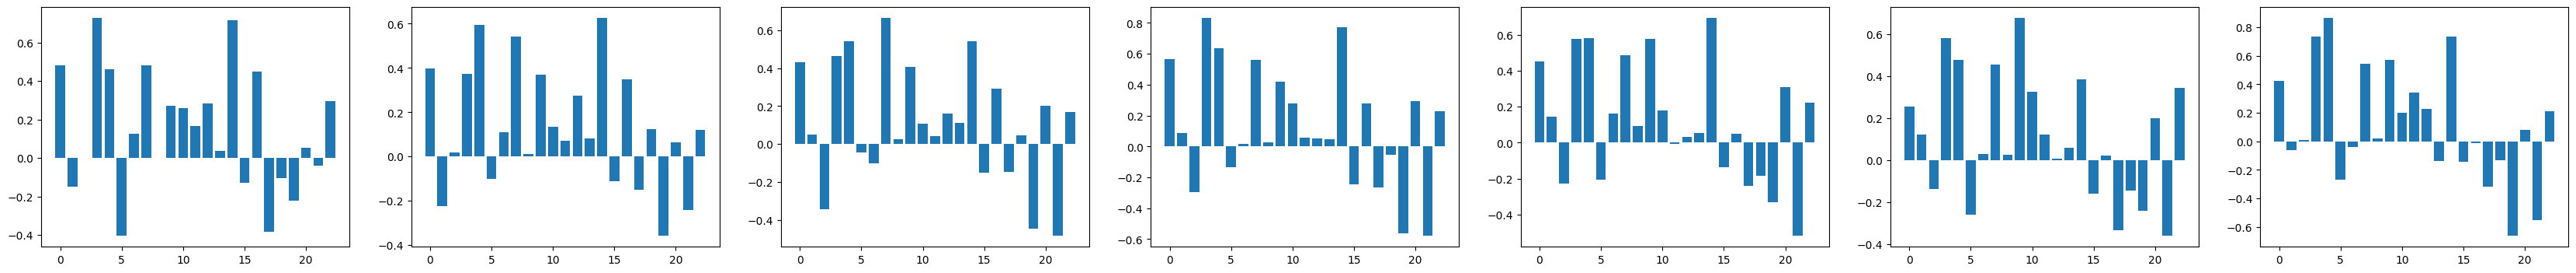

In [29]:
from style import plot_grads
n_plot = 7
skip = len(ts) // (n_plot-1)
plot_ts = np.arange(0, len(ts), skip)
plot_grads(p_curve_grads[plot_ts, 0], nrows=1, ncols=n_plot)

In [30]:
def curve_grads1(p_curve, ts=np.linspace(0,1,101)):
    p_curve_grads = np.zeros((len(ts), *X_test.shape))
    for i, t in enumerate(ts):
        model = get_model_from_curve(p_curve=p_curve, t=t)
        p_curve_grads[i] = model.compute_gradients(X_test, return_numpy=True)
    return p_curve_grads

import torch.nn as nn
def curve_grads2(p_curve, ts=np.linspace(0,1,101)):
    models = nn.ModuleList(modules=[get_model_from_curve(p_curve=p_curve, t=t) for t in ts])
    p_curve_grads = [model.compute_gradients(X_test, return_numpy=True) for model in models]
    return np.array(p_curve_grads)
    
model_class = get_model_class(name)
def curve_grads3(p_curve, ts=np.linspace(0,1,101)):
    p_curve_grads = p_curve.compute_gradients(X_test, model_class, ts)
    return p_curve_grads

In [38]:
p_curve_grads.shape

(101, 1975, 23)

In [21]:
%timeit curve_grads1(p_curve, ts=np.linspace(0,1,101))

189 ms ± 5.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
%timeit curve_grads2(p_curve, ts=np.linspace(0,1,101))

154 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
%timeit curve_grads3(p_curve, ts=np.linspace(0,1,101))

143 ms ± 4.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [31]:
p_curve_grads1 = curve_grads1(p_curve, ts=np.linspace(0,1,101))
p_curve_grads2 = curve_grads2(p_curve, ts=np.linspace(0,1,101))
p_curve_grads3 = curve_grads3(p_curve, ts=np.linspace(0,1,101))

assert np.allclose(p_curve_grads1, p_curve_grads2)
assert np.allclose(p_curve_grads1, p_curve_grads3)
assert np.allclose(p_curve_grads2, p_curve_grads3)

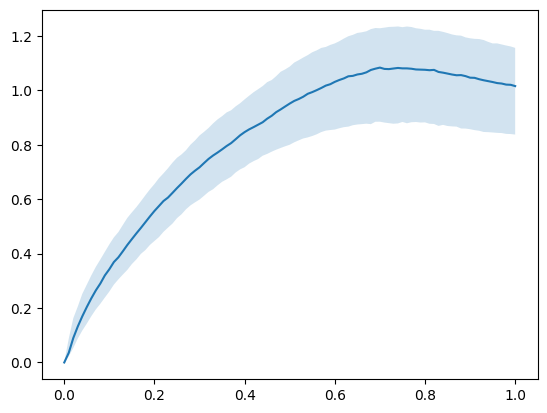

In [99]:
weight_diffs = np.zeros(len(ts))
grad_diffs = np.zeros((len(ts), X_test.shape[0]))
SA = np.zeros((len(ts), X_test.shape[0]))
for i, t in enumerate(ts):
    model_0 = get_model_from_curve(p_curve=p_curve, t=0)
    model_t = get_model_from_curve(p_curve=p_curve, t=t)
    weight_diffs[i] = get_weight_diff(model_0.state_dict(), model_t.state_dict())
    grad_0, grad_t = model_0.compute_gradients(X_test, return_numpy=True), model_t.compute_gradients(X_test, return_numpy=True)
    grad_diffs[i] = np.linalg.norm(grad_0-grad_t, axis=1)
    tk_0, s_0 = get_top_k(5, grad_0, return_sign=True)
    tk_t, s_t = get_top_k(5, grad_t, return_sign=True)
    SA[i] = top_k_sa(tk_0, tk_t, s_0, s_t)
#plt.plot(ts, weight_diffs)
q = np.quantile(grad_diffs, q=[0.25, 0.5, 0.75], axis=1)
plt.plot(ts, q[1])
plt.fill_between(ts, q[0], q[2], alpha=0.2)
plt.show()

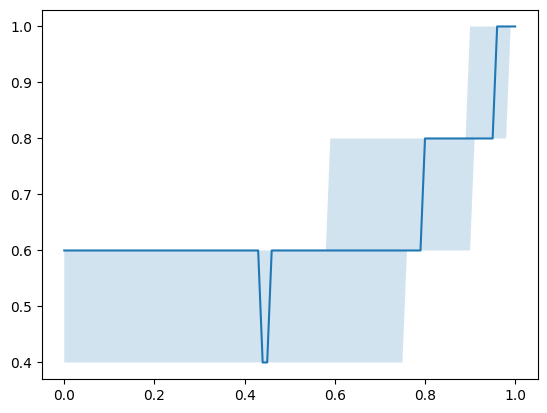

In [95]:
q = np.quantile(SA, q=[0.25, 0.5, 0.75], axis=1)
plt.plot(ts, q[1])
plt.fill_between(ts, q[0], q[2], alpha=0.2)
plt.show()

### Path to Glory

In [159]:
# Test point indices
test_idx = range(X_test.shape[0])
x = X_test[test_idx]

# Random source
random_source = random_sources[0]

# Number of ensembles to sample
n_trials = 10

# Top-k features to consider
k = 5

# Store no. inputs and no. features
n_inputs, n_features = X_test.shape

# Curve/Segment/Smooth Params
ts = np.linspace(0,1,21)
n_weight_perturbations = 100
sigma = 0.5

# Ensemble
ensemble_size = 2  # rough optimal epochs for 2, 3, 4, 5: 30, 40, 60, 80

In [160]:
# Compute random pairs
# Compute random mode-connected pairs
# Compute random perturbed pairs

topk_avg, signs_avg = np.zeros((n_trials, n_inputs, k)), np.zeros((n_trials, n_inputs, k))
topk_smooth, signs_smooth = np.zeros((n_trials, n_inputs, k)), np.zeros((n_trials, n_inputs, k))
topk_mode, signs_mode = np.zeros((n_trials, n_inputs, k)), np.zeros((n_trials, n_inputs, k))
topk_mode_smooth, signs_mode_smooth = np.zeros((n_trials, n_inputs, k)), np.zeros((n_trials, n_inputs, k))
# topk_seg, signs_seg = np.zeros((n_trials, n_inputs, k)), np.zeros((n_trials, n_inputs, k))
# topk_seg_smooth, signs_seg_smooth = np.zeros((n_trials, n_inputs, k)), np.zeros((n_trials, n_inputs, k))

accs_avg = np.zeros(n_trials)
accs_smooth = np.zeros(n_trials)
accs_mode = np.zeros(n_trials)
accs_mode_smooth = np.zeros(n_trials)
# accs_seg = np.zeros(n_trials)
# accs_seg_smooth = np.zeros(n_trials)
model_class = get_model_class(name)

for i in tqdm(range(n_trials)):
    # Sample random models
    model_idx = range(800+i*ensemble_size, 800+(i+1)*ensemble_size)
    
    # Load predictions/gradients
    grads = np.array([np.load(f'{directory}/{random_source}_grads_{idx}.npy') for idx in model_idx])
    logits = np.array([np.load(f'{directory}/{random_source}_logits_{idx}.npy') for idx in model_idx]).mean(axis=0)
    preds = logits.argmax(axis=1)

    grads_smooth = np.array([np.load(f'{directory}/{random_source}_grads_smooth_{idx}.npy') for idx in model_idx])
    logits_smooth = np.array([np.load(f'{directory}/{random_source}_logits_smooth_{idx}.npy') for idx in model_idx]).mean(axis=0)
    preds_smooth = logits_smooth.argmax(axis=1)

    # Mode connectivity
    #start_model, end_model = load_model(model_idx[0]), load_model(model_idx[1])
    models = [init_model(idx) for idx in model_idx]
    p_curve, logits_mode, grads_mode = mode_connect(models, trainloader=trainloader_full, lr=0.0004,
                                                     momentum=0, epochs=30, curve_type='bezier', ts=ts,
                                                     disable_tqdm=False, init='none', target_loss=0)
        # models, trainloader=trainloader_full,
        #                                             lr=0.1, momentum=0,
        #                                              epochs=80, curve_type='bezier',
        #                                              ts=ts, disable_tqdm=True,
        #                                              init='none', target_loss=0)
                                                    #  num_bends=3, lr=0.1, momentum=0,
                                                    #  epochs=20, curve_type='polychain',
                                                    #  ts=ts, disable_tqdm=True,
                                                    #  init='radial', target_loss=0)
    preds_mode = logits_mode.mean(axis=0).argmax(axis=1)

    # Perturb Curve
    logits_mode_smooth, grads_mode_smooth = perturb_curve(p_curve, ts=ts,
                                                     n_weight_perturbations=n_weight_perturbations,
                                                     sigma=sigma, disable_tqdm=True)
    preds_mode_smooth = logits_mode_smooth.mean(axis=(0,1)).argmax(axis=1)
    
    # # Segment
    # state_dict1, state_dict2 = load_model(model_idx[0]).state_dict(), load_model(model_idx[1]).state_dict()
    # state_dicts = linear_weight_interpolation(state_dict1, state_dict2, ts=ts)
    # logits_seg, grads_seg = eval_segment(state_dicts, disable_tqdm=True)
    # logits_seg_smooth, grads_seg_smooth = perturb_segment(state_dicts, n_weight_perturbations,
    #                                                       sigma, disable_tqdm=True)
    
    # Compute top-k features
    topk_avg[i], signs_avg[i] = get_top_k(k=k, X=grads.mean(axis=0), return_sign=True)
    topk_smooth[i], signs_smooth[i] = get_top_k(k=k, X=grads_smooth.mean(axis=0), return_sign=True)
    topk_mode[i], signs_mode[i] = get_top_k(k=k, X=grads_mode.mean(axis=0), return_sign=True)
    topk_mode_smooth[i], signs_mode_smooth[i] = get_top_k(k=k, X=grads_mode_smooth.mean(axis=(0,1)), return_sign=True)
    # topk_seg[i], signs_seg[i] = get_top_k(k=k, X=grads_seg.mean(axis=0), return_sign=True)
    # topk_seg_smooth[i], signs_seg_smooth[i] = get_top_k(k=k, X=grads_seg_smooth.mean(axis=(0,1)), return_sign=True)

    # Accuracies
    accs_avg[i] = (preds == y_test).mean()
    accs_smooth[i] = (preds_smooth == y_test).mean()
    accs_mode[i] = (preds_mode == y_test).mean()
    accs_mode_smooth[i] = (preds_mode_smooth == y_test).mean()
    # accs_seg[i] = (logits_seg.mean(axis=0).argmax(1) == y_test).mean()
    # accs_seg_smooth[i] = (logits_seg_smooth.mean(axis=(0,1)).argmax(1) == y_test).mean()

100%|██████████| 10/10 [02:32<00:00, 15.20s/it]


In [161]:
SA_avg = average_pairwise_score(topk_avg, signs_avg, top_k_sa)
SA_smooth = average_pairwise_score(topk_smooth, signs_smooth, top_k_sa)
SA_mode = average_pairwise_score(topk_mode, signs_mode, top_k_sa)
SA_mode_smooth = average_pairwise_score(topk_mode_smooth, signs_mode_smooth, top_k_sa)
# SA_seg = average_pairwise_score(topk_seg, signs_seg, top_k_sa)
# SA_seg_smooth = average_pairwise_score(topk_seg_smooth, signs_seg_smooth, top_k_sa)

# grads_gt = np.array([np.load(f'{directory}/{random_source}_grads_{idx}.npy') for idx in range(n_models)]).mean(axis=0)
# topk_gt, signs_gt = get_top_k(k=k, X=grads_gt, return_sign=True)
# SA_avg_gt = average_ground_truth_score(topk_avg, signs_avg, topk_gt, signs_gt, top_k_sa)
# SA_smooth_gt = average_ground_truth_score(topk_smooth, signs_smooth, topk_gt, signs_gt, top_k_sa)
# SA_mode_gt = average_ground_truth_score(topk_mode, signs_mode, topk_gt, signs_gt, top_k_sa)
# SA_mode_norm_gt = average_ground_truth_score(topk_mode_norm, signs_mode_norm, topk_gt, signs_gt, top_k_sa)

In [175]:
grads = np.array([np.load(f'{directory}/{random_source}_grads_{idx}.npy') for idx in range(800, 820, 2)])
preds = np.array([np.load(f'{directory}/{random_source}_preds_{idx}.npy') for idx in range(800, 820, 2)])
accs_single = (preds == y_test).mean(axis=1)
topk, signs = get_top_k(k=k, X=grads, return_sign=True)
SA_single = average_pairwise_score(topk, signs, top_k_sa)

In [176]:
np.median(SA_single), np.median(SA_avg), np.median(SA_smooth), np.median(SA_mode), np.median(SA_mode_smooth)

(0.5111111111111113,
 0.6355555555555558,
 0.7333333333333338,
 0.7600000000000003,
 0.8266666666666669)

In [177]:
logits_mode_smooth.mean(axis=(0,1)).argmax(axis=1).mean()

0.010126582278481013

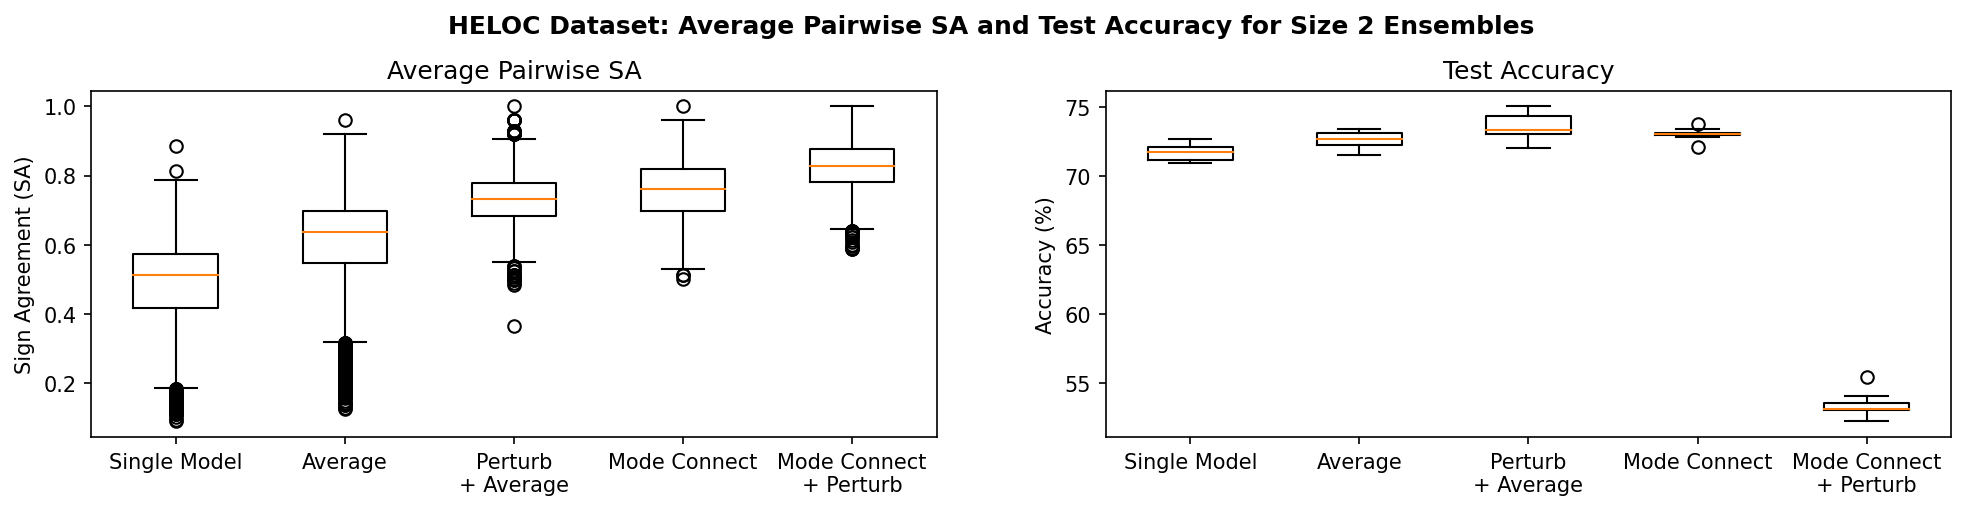

In [178]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 3), dpi=150)
labels = ['Single Model', 'Average', 'Perturb\n+ Average', 'Mode Connect', 'Mode Connect\n+ Perturb']
ax[0].boxplot([SA_single, SA_avg, SA_smooth, SA_mode, SA_mode_smooth],#, SA_seg, SA_seg_smooth],
              labels=labels)#, 'Segment', 'Segment + Perturb'])
ax[0].set_ylabel('Sign Agreement (SA)')
ax[0].set_title('Average Pairwise SA')
# ax[1].boxplot([SA_avg_gt, SA_smooth_gt, SA_mode_gt, SA_mode_norm_gt], labels=['Average', 'Perturb + Average', 'Polychain', 'Polychain Norm'])
# ax[1].set_ylabel('SA (Ground Truth)')
# ax[1].set_title('Average Ground Truth SA')
ax[1].boxplot([100*accs_single, 100*accs_avg, 100*accs_smooth, 100*accs_mode, 100*accs_mode_smooth],#, 100*accs_seg, 100*accs_seg_smooth],
              labels=labels)#, 'Segment', 'Segment + Perturb'])
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title('Test Accuracy')
plt.suptitle(f'HELOC Dataset: Average Pairwise SA and Test Accuracy for Size {ensemble_size} Ensembles',
             fontweight='bold', y=1.05)
plt.show()

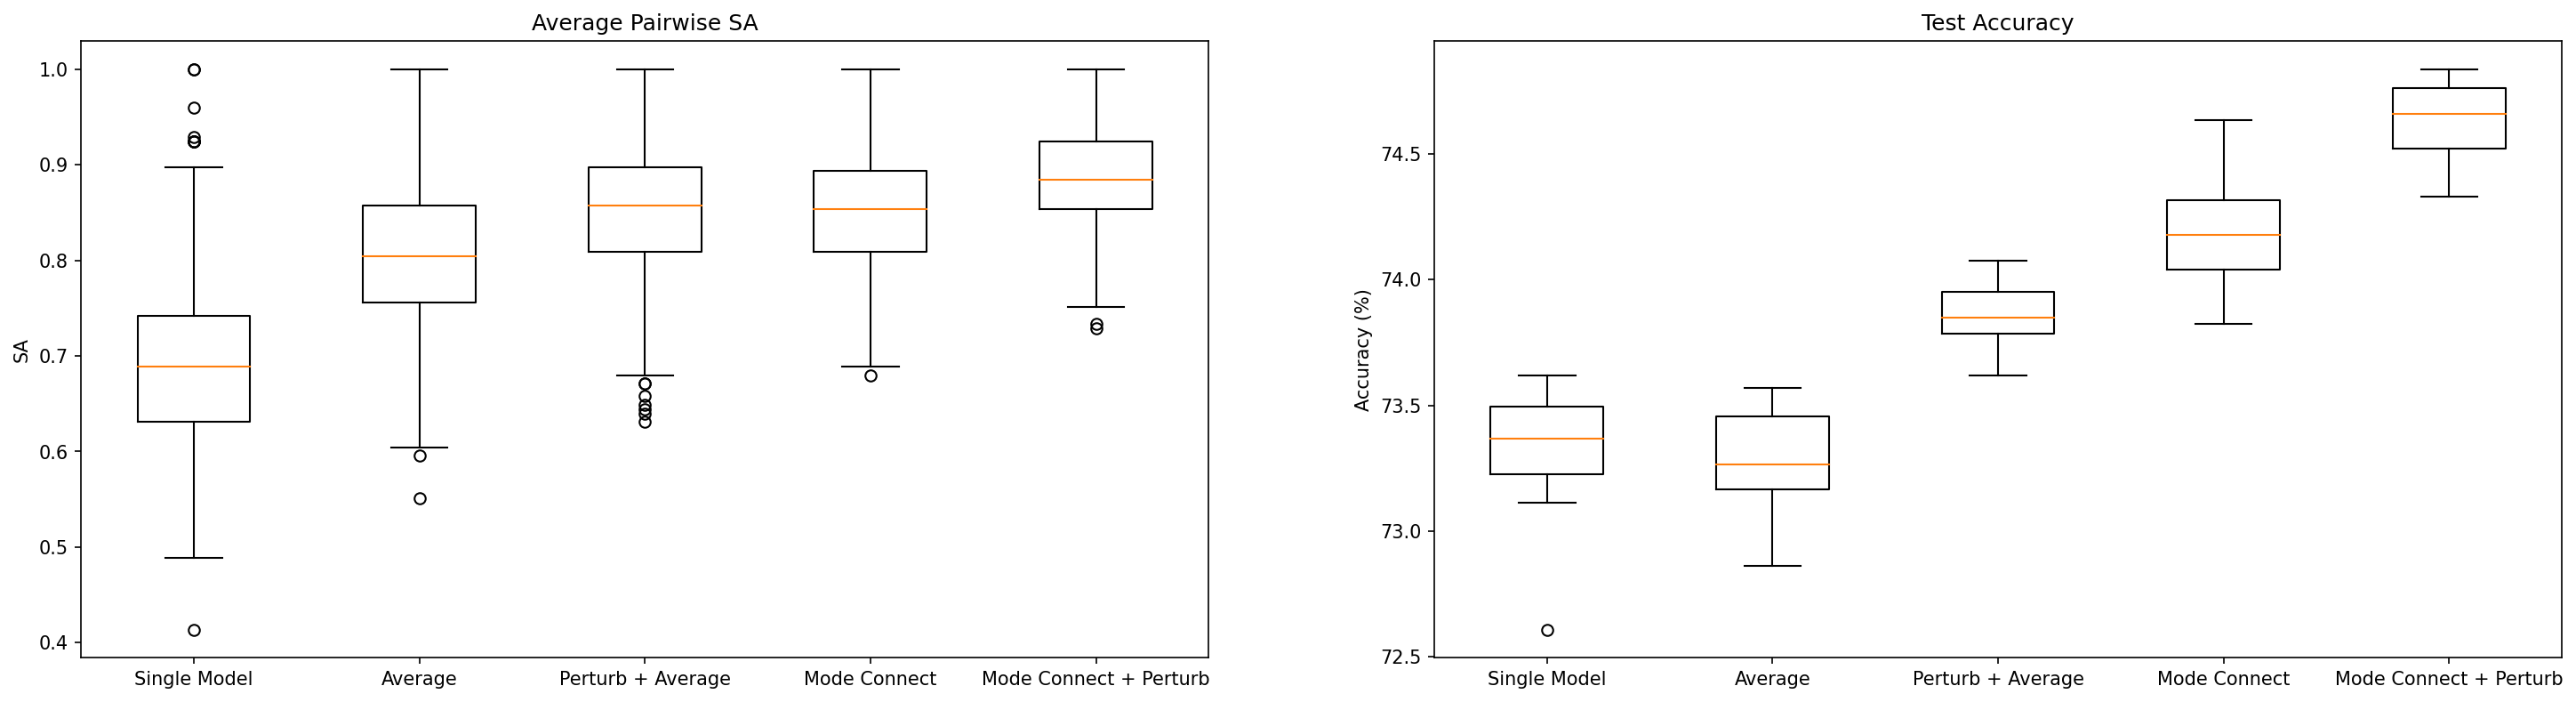

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 6), dpi=150)
labels = ['Single Model', 'Average', 'Perturb + Average', 'Mode Connect', 'Mode Connect + Perturb']
ax[0].boxplot([SA_single, SA_avg, SA_smooth, SA_mode, SA_mode_smooth],#, SA_seg, SA_seg_smooth],
              labels=labels)#, 'Segment', 'Segment + Perturb'])
ax[0].set_ylabel('SA')
ax[0].set_title('Average Pairwise SA')
# ax[1].boxplot([SA_avg_gt, SA_smooth_gt, SA_mode_gt, SA_mode_norm_gt], labels=['Average', 'Perturb + Average', 'Polychain', 'Polychain Norm'])
# ax[1].set_ylabel('SA (Ground Truth)')
# ax[1].set_title('Average Ground Truth SA')
ax[1].boxplot([100*accs_single, 100*accs_avg, 100*accs_smooth, 100*accs_mode, 100*accs_mode_smooth],#, 100*accs_seg, 100*accs_seg_smooth],
              labels=labels)#, 'Segment', 'Segment + Perturb'])
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title('Test Accuracy')
plt.show()

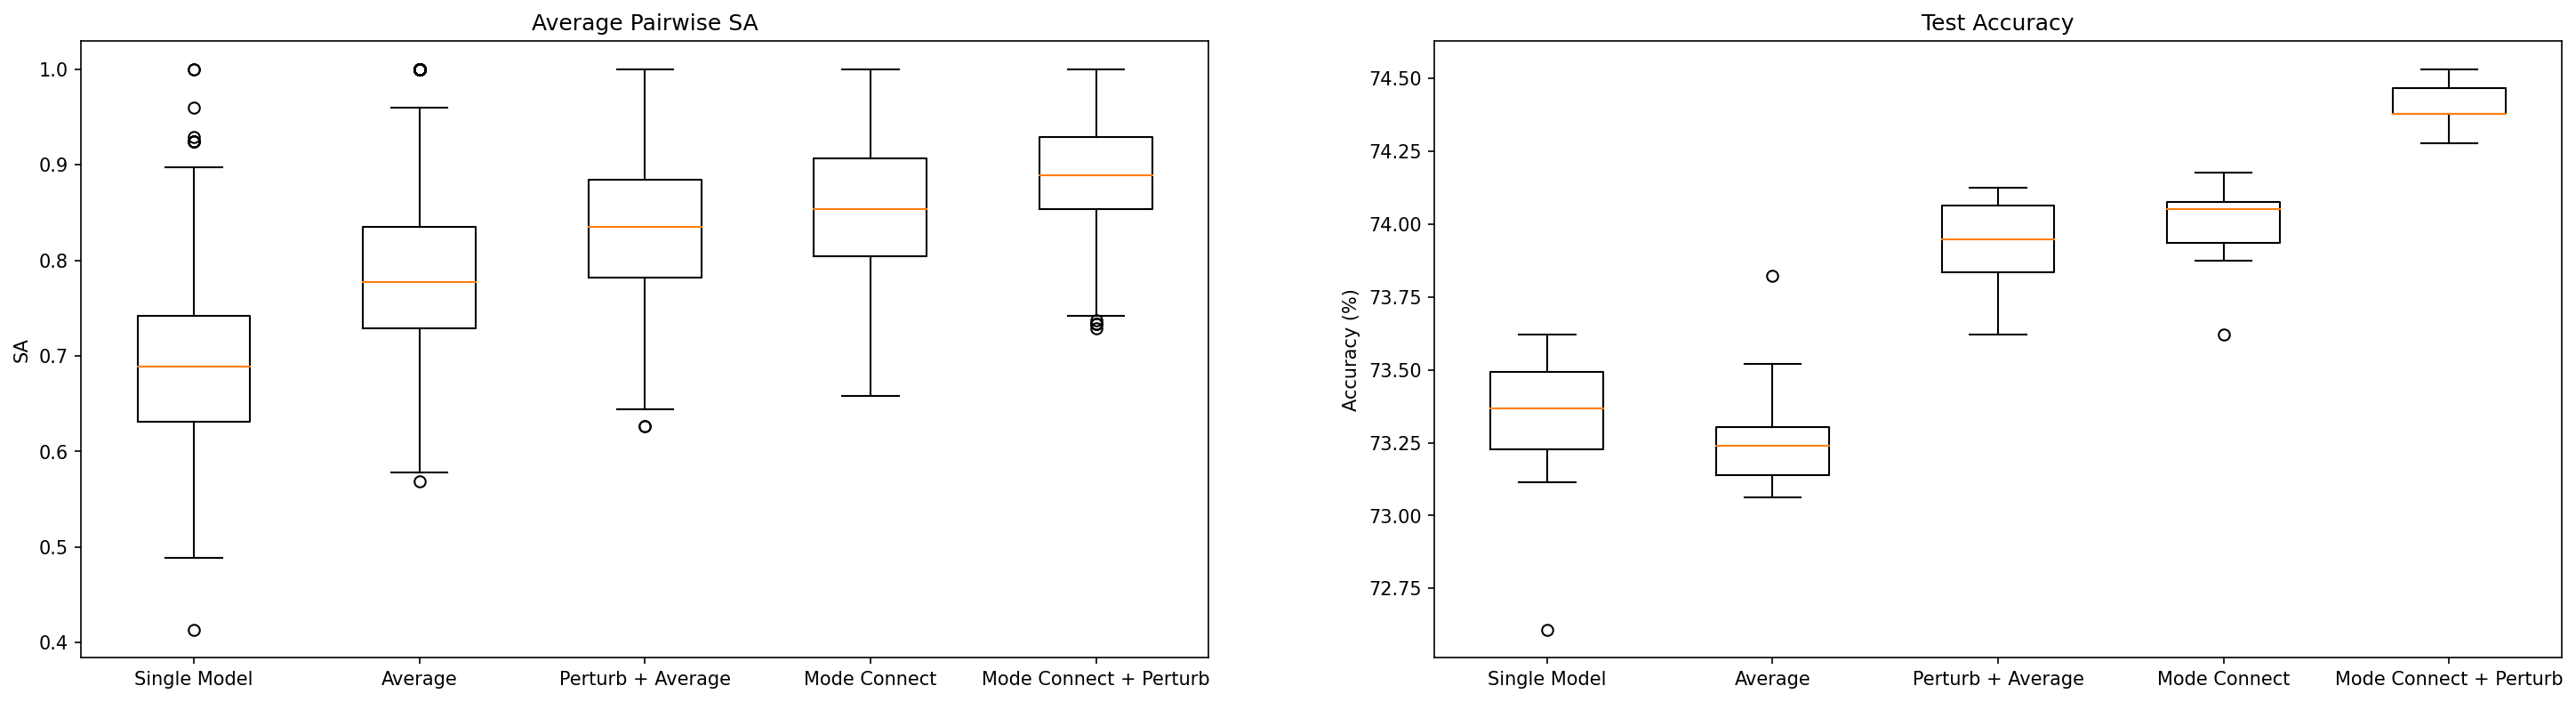

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 6), dpi=150)
labels = ['Single Model', 'Average', 'Perturb + Average', 'Mode Connect', 'Mode Connect + Perturb']
ax[0].boxplot([SA_single, SA_avg, SA_smooth, SA_mode, SA_mode_smooth],#, SA_seg, SA_seg_smooth],
              labels=labels)#, 'Segment', 'Segment + Perturb'])
ax[0].set_ylabel('SA')
ax[0].set_title('Average Pairwise SA')
# ax[1].boxplot([SA_avg_gt, SA_smooth_gt, SA_mode_gt, SA_mode_norm_gt], labels=['Average', 'Perturb + Average', 'Polychain', 'Polychain Norm'])
# ax[1].set_ylabel('SA (Ground Truth)')
# ax[1].set_title('Average Ground Truth SA')
ax[1].boxplot([100*accs_single, 100*accs_avg, 100*accs_smooth, 100*accs_mode, 100*accs_mode_smooth],#, 100*accs_seg, 100*accs_seg_smooth],
              labels=labels)#, 'Segment', 'Segment + Perturb'])
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title('Test Accuracy')
plt.show()

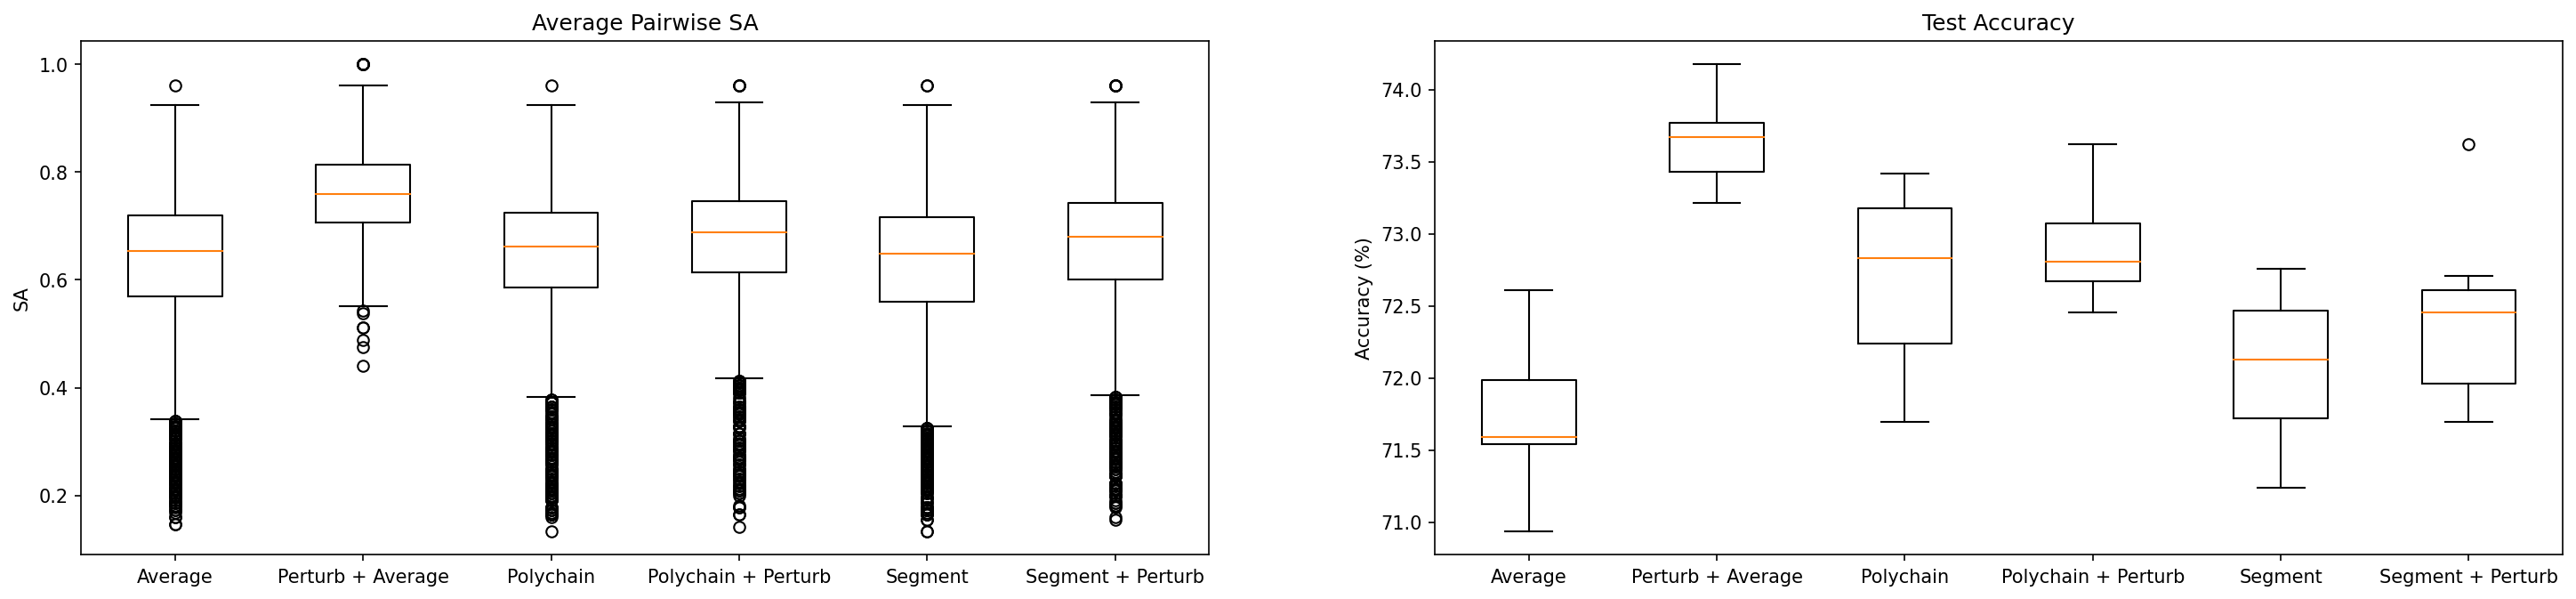

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 5), dpi=150)
ax[0].boxplot([SA_avg, SA_smooth, SA_mode, SA_mode_smooth, SA_seg, SA_seg_smooth],
              labels=['Average', 'Perturb + Average', 'Polychain', 'Polychain + Perturb', 'Segment', 'Segment + Perturb'])
ax[0].set_ylabel('SA')
ax[0].set_title('Average Pairwise SA')
# ax[1].boxplot([SA_avg_gt, SA_smooth_gt, SA_mode_gt, SA_mode_norm_gt], labels=['Average', 'Perturb + Average', 'Polychain', 'Polychain Norm'])
# ax[1].set_ylabel('SA (Ground Truth)')
# ax[1].set_title('Average Ground Truth SA')
ax[1].boxplot([100*accs_avg, 100*accs_smooth, 100*accs_mode, 100*accs_mode_smooth, 100*accs_seg, 100*accs_seg_smooth],
              labels=['Average', 'Perturb + Average', 'Polychain', 'Polychain + Perturb', 'Segment', 'Segment + Perturb'])
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title('Test Accuracy')
plt.show()

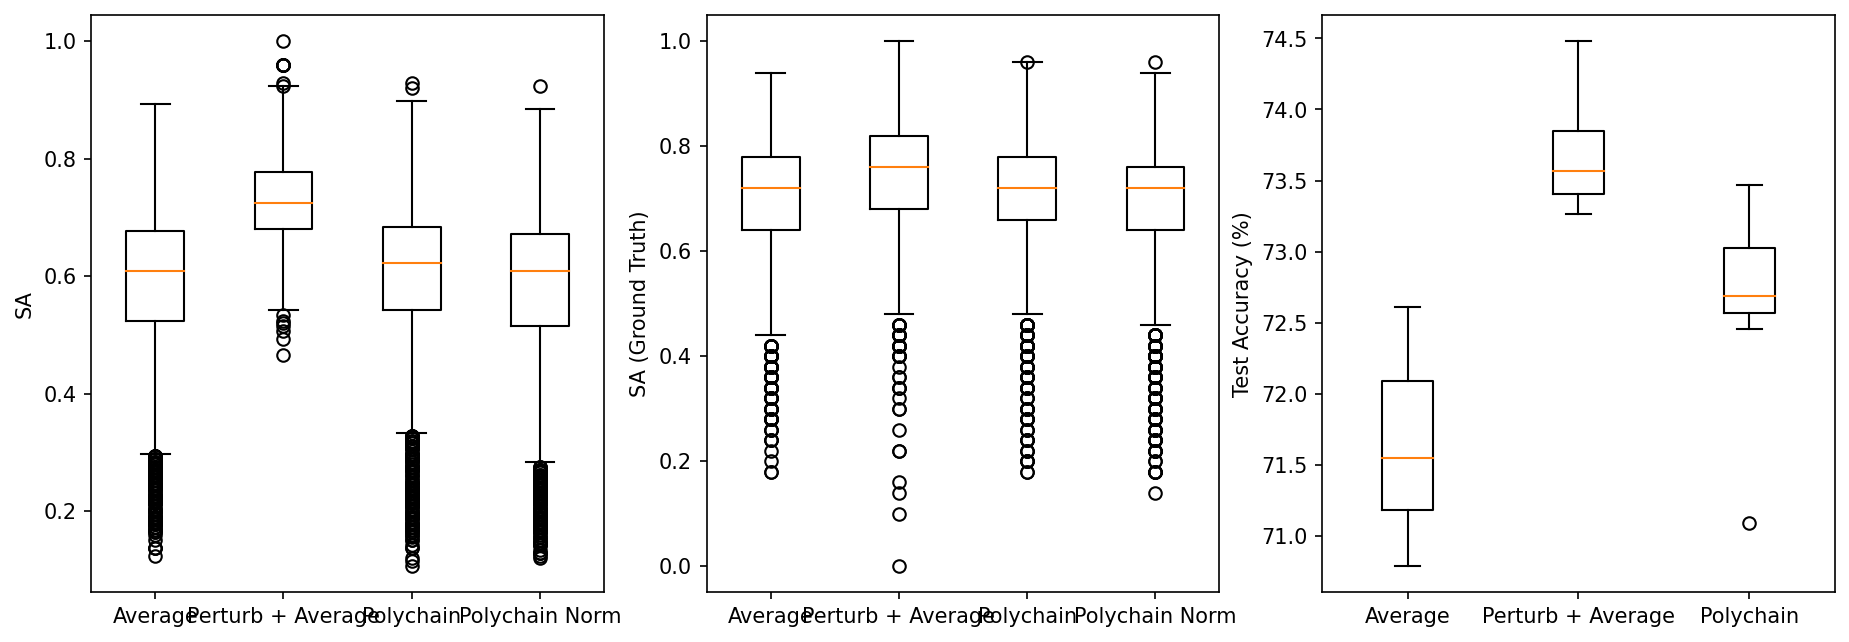

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5), dpi=150)
ax[0].boxplot([SA_avg, SA_smooth, SA_mode, SA_mode_norm], labels=['Average', 'Perturb + Average', 'Polychain', 'Polychain Norm'])
ax[0].set_ylabel('SA')
ax[0].set_title('Average Pairwise SA')
ax[1].boxplot([SA_avg_gt, SA_smooth_gt, SA_mode_gt, SA_mode_norm_gt], labels=['Average', 'Perturb + Average', 'Polychain', 'Polychain Norm'])
ax[1].set_ylabel('SA (Ground Truth)')
ax[1].set_title('Average Ground Truth SA')
ax[2].boxplot([100*accs_avg, 100*accs_smooth, 100*accs_mode], labels=['Average', 'Perturb + Average', 'Polychain'])
ax[2].set_ylabel('Accuracy (%)')
ax[2].set_title('Test Accuracy')
plt.show()

# Segment + Perturbation

In [174]:
def linear_weight_interpolation(state_dict1, state_dict2, ts):
    # Interpolate between two state dicts
    state_dicts = []
    for t in ts:
        state_dict = {}
        for key in state_dict1.keys():
            state_dict[key] = state_dict1[key] + (state_dict2[key] - state_dict1[key]) * t
        state_dicts.append(state_dict)
    return state_dicts

100%|██████████| 101/101 [00:00<00:00, 115.08it/s]


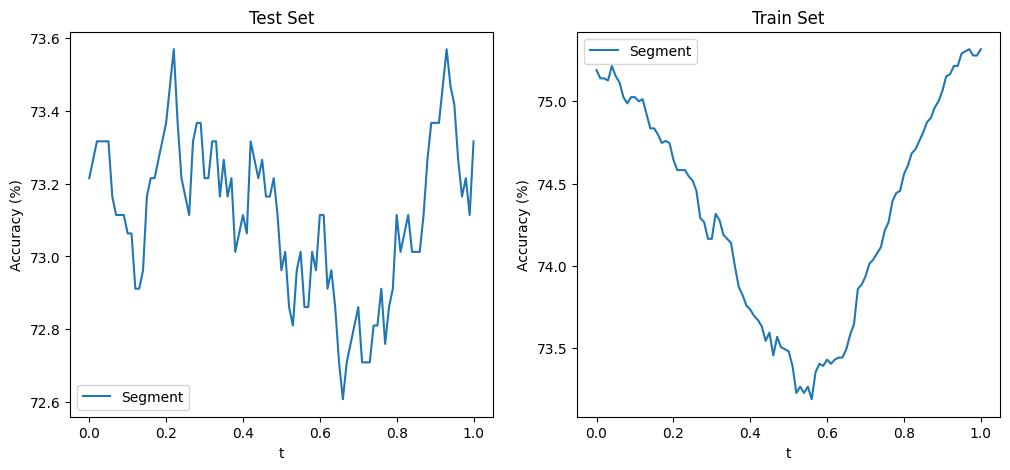

In [48]:
# Interpolate between two state dicts
ts = np.linspace(0.0, 1.0, 101)
state_dict1 = torch.load(f'{directory}/{random_source}_model_{0}.pth')
state_dict2 = torch.load(f'{directory}/{random_source}_model_{1}.pth')
state_dicts = linear_weight_interpolation(state_dict1, state_dict2, ts)


# For each state dict, compute the accuracy on the test set
segment_accs = []
segment_accs_tr = []
model = model_class(*model_args)
for state_dict in tqdm(state_dicts):
    model.load_state_dict(state_dict)
    segment_accs.append((model.predict(X_test).numpy() == y_test).mean())
    segment_accs_tr.append((model.predict(X_train).numpy() == y_train).mean())

# Plot both plots below on one row, two columns
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=100)
accs = [segment_accs, segment_accs_tr]
labs = ['Test Set', 'Train Set']
for i in range(2):
    ax[i].plot(ts, 100*np.array(accs[i]), label='Segment')
    ax[i].set_xlabel('t')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_title(labs[i])
    ax[i].legend()
plt.show()

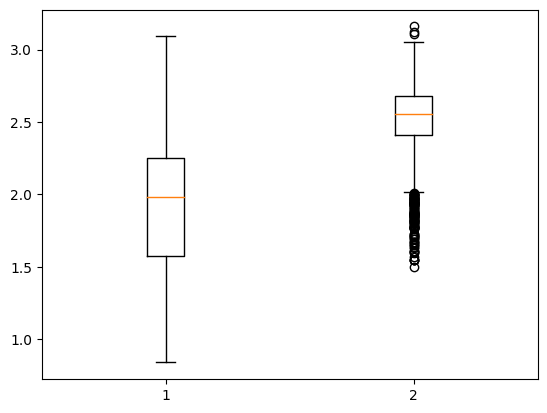

In [118]:
n_weight_perturbations = 100
sigma = 0.2

model_class = get_model_class(name)
model = load_model(0)
model_pert = TabularModelPerturb(model, n_weight_perturbations, sigma)
pert_grad = model_pert.compute_gradients(X_test, mean=False)
pert_pred, pert_pred_tr = model_pert.predict(X_test), model_pert.predict(X_train)
grad = model.compute_gradients(X_test)
pred = model.predict(X_test)
pred_tr = model.predict(X_train)

fig, ax = plt.subplots(nrows=1, ncols=3, dpi=100)
ax[0].boxplot([np.linalg.norm(grad, axis=1), np.linalg.norm(pert_grad, axis=2).mean(axis=0)])
ax[1].boxplot([])
plt.show()

In [49]:
state_dict1 = torch.load(f'{directory}/{random_source}_model_{0}.pth')
state_dict2 = torch.load(f'{directory}/{random_source}_model_{1}.pth')
ts=np.linspace(0, 1, 21)
state_dicts = linear_weight_interpolation(state_dict1, state_dict2, ts)

In [97]:
model_class = get_model_class(name)
accs_smooth_tr, grads_smooth = perturb_curve(p_curve, ts=np.linspace(0,1,21),
                                             n_weight_perturbations=100, sigma=0.1, disable_tqdm=False)

21it [00:10,  1.97it/s]


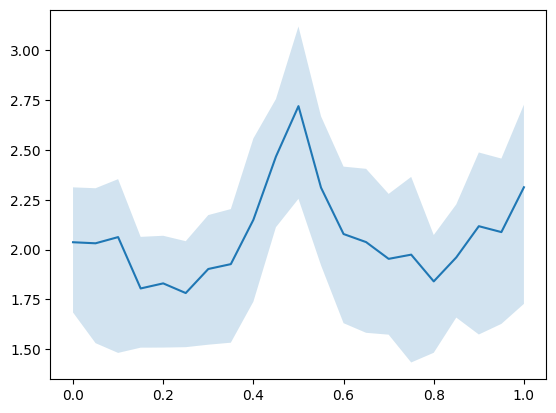

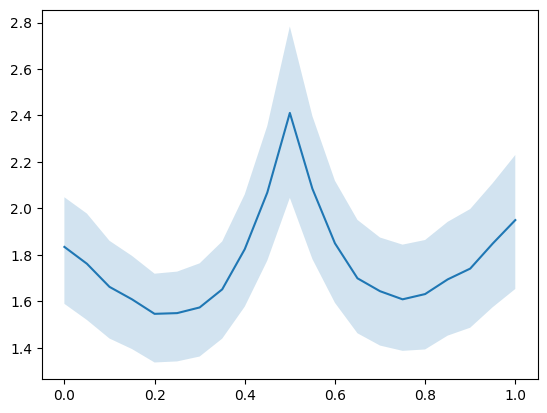

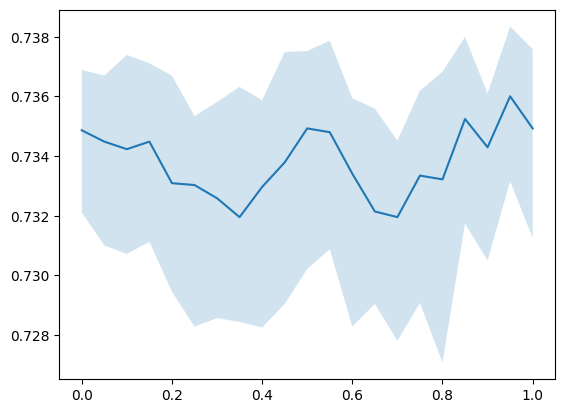

In [102]:
best_grads = np.array([grads_smooth[i, np.argmax(accs_smooth_tr[i])] for i in range(len(ts))])
q = np.quantile(np.linalg.norm(best_grads, axis=2), [0.25, 0.5, 0.75], axis=1)
plt.plot(ts, q[1])
plt.fill_between(ts, q[0], q[2], alpha=0.2)
plt.show()

# Plot average gradient norms
q = np.quantile(np.linalg.norm(grads_smooth.mean(axis=1), axis=2), [0.25, 0.5, 0.75], axis=1)
plt.plot(ts, q[1])
plt.fill_between(ts, q[0], q[2], alpha=0.2)
plt.show()

# Plot best accuracy for each t
q = np.quantile(accs_smooth_tr, [0.25, 0.5, 0.75], axis=1)
plt.plot(ts, q[1])
plt.fill_between(ts, q[0], q[2], alpha=0.2)
plt.show()

In [44]:
def segment_perturb(state_dicts, n_weight_perturbations=100, sigma=0.5, disable_tqdm=True):
    # For each state dict, perturb the first layer weights
    preds_smooth = np.zeros((len(state_dicts), n_weight_perturbations, *y_test.shape))
    preds_smooth_tr = np.zeros((len(state_dicts), n_weight_perturbations, *y_train.shape))
    accs_smooth = np.zeros((len(state_dicts), n_weight_perturbations))
    accs_smooth_tr = np.zeros((len(state_dicts), n_weight_perturbations))
    grads_smooth = np.zeros((len(state_dicts), n_weight_perturbations, *X_test.shape))
    grads_smooth_tr = np.zeros((len(state_dicts), n_weight_perturbations, *X_train.shape))

    for i, state_dict in tqdm(enumerate(state_dicts), disable=disable_tqdm):
        model = model_class(*model_args)
        model.load_state_dict(state_dict)
        pert_model = TabularModelPerturb(model, n_weight_perturbations, sigma)
        preds_smooth[i] = pert_model.predict(X_test, mean=False)
        preds_smooth_tr[i] = pert_model.predict(X_train, mean=False)
        accs_smooth[i] = (preds_smooth[i] == y_test).mean(axis=1)
        accs_smooth_tr[i] = (preds_smooth_tr[i] == y_train).mean(axis=1)
        grads_smooth[i] = pert_model.compute_gradients(X_test, mean=False)
        grads_smooth_tr[i] = pert_model.compute_gradients(X_train, mean=False)
    return accs_smooth, accs_smooth_tr, grads_smooth, grads_smooth_tr

In [65]:
accs_smooth, accs_smooth_tr, grads_smooth, grads_smooth_tr =\
    segment_perturb(state_dicts, n_weight_perturbations=100, sigma=0.1, disable_tqdm=False)

21it [00:26,  1.27s/it]


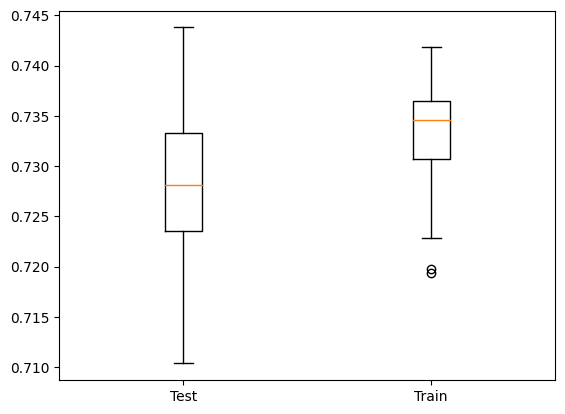

[0.7331645569620253, 0.7531661600810537]


In [66]:
orig_accs = [[(load_model(0).predict(X_test, return_numpy=True)==y_test).mean(), (load_model(0).predict(X_train, return_numpy=True)==y_train).mean()],
             [(load_model(1).predict(X_test, return_numpy=True)==y_test).mean(), (load_model(1).predict(X_train, return_numpy=True)==y_train).mean()]]
test_acc = (TabularModelPerturb(load_model(1), 100, 0.1).predict(X_test, mean=False)==y_test).mean(axis=1)
train_acc = (TabularModelPerturb(load_model(1), 100, 0.1).predict(X_train, mean=False)==y_train).mean(axis=1)
plt.boxplot([test_acc, train_acc], labels=['Test', 'Train'])
plt.show()
print(orig_accs[1])

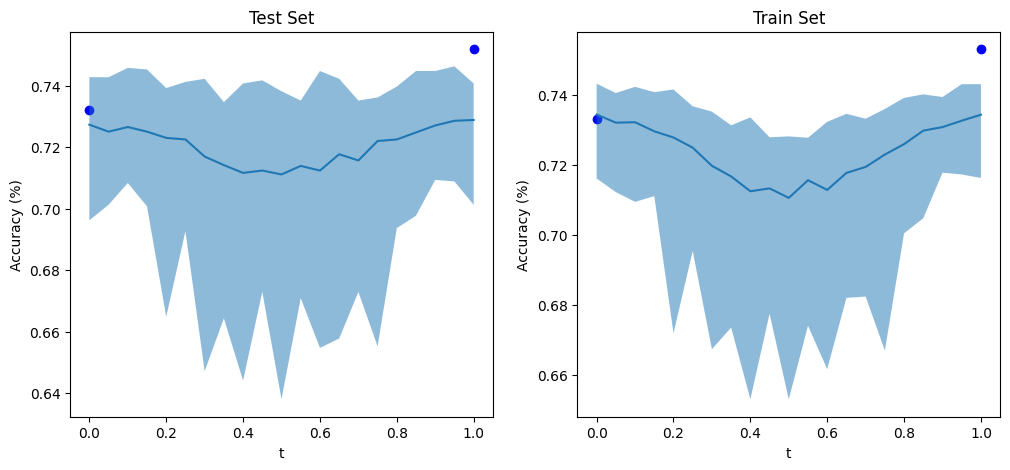

In [67]:
# Plot test and train on two columns
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=100)
accs = [accs_smooth, accs_smooth_tr]
labs = ['Test Set', 'Train Set']
orig_accs = [[(load_model(0).predict(X_test, return_numpy=True)==y_test).mean(), (load_model(0).predict(X_train, return_numpy=True)==y_train).mean()],
             [(load_model(1).predict(X_test, return_numpy=True)==y_test).mean(), (load_model(1).predict(X_train, return_numpy=True)==y_train).mean()]]
for i in range(2):
    q = np.quantile(accs[i], [0, 0.5, 1.0], axis=1)
    ax[i].plot(ts, q[1])
    ax[i].scatter([0,1], orig_accs[i], color='blue')
    ax[i].fill_between(ts, q[0], q[2], alpha=0.5)
    ax[i].set_xlabel('t')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_title(labs[i])
plt.show()

In [90]:
best_accs = accs_smooth_tr.argmax(1)
# For each element in grads_smooth, select the best_accs[i]th row
best_grads = np.array([grads_smooth[i, best_accs[i]] for i in range(len(best_accs))])
best_grads.shape

(21, 1975, 23)

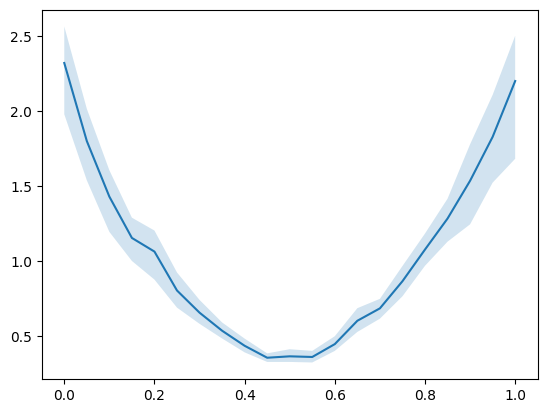

In [91]:
q = np.quantile(np.linalg.norm(best_grads, axis=2), [0.25, 0.5, 0.75], axis=1)
plt.plot(ts, q[1])
plt.fill_between(ts, q[0], q[2], alpha=0.2)
plt.show()